

# Tarea Final - Machine Learning


Alumno: Guillermo Lodeiro

Profesores: Jose Angel Carballo, Luis Garmendia, María José Gómez

Institución: Universidad Complutense de Madrid

A lo largo del proyecto se fueron probando distintas alternativas para llegar a un mejor rendimiento del modelo. Entre ellas, se eliminaron e imputaron variables de distintas formas, tambien se codificaron las variables mediante label_encoder, get_dummies, etc, en busca de la mejor opcion. Tambien se trabajo con el balanceo de datos, en la varaible objetivo resulto positivo utilizar SMOTE para aumentar la cantidad de 'functional needs repair'. Se penso tambien desde el lado de feature engineering, donde una de las opciones fue crear la variable distancia euclidiana, con la ayuda de las vairables 'longitude' y 'latitude'.


In [1]:
#Cargo algunas de las librerías que utilizaré

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargo los 3 archivos necesarios para la tarea

training_set_values = pd.read_csv('Training_Set_Values.csv')
test_set_values = pd.read_csv('Test_Set_Values.csv')
training_set_labels = pd.read_csv('Training_Set_Labels.csv')

In [3]:
training_set_values.shape # 80% de lo que sería el dataset completo

(59400, 40)

In [4]:
test_set_values.shape # 20% de lo que sería el dataset completo

(14850, 40)

In [5]:
training_set_labels.shape

(59400, 2)

In [6]:
## Hago un join con para tener las etiquetas junto al conjunto de entrenamiento.

data = pd.merge(training_set_values, training_set_labels, on='id', how='left')

data.shape

(59400, 41)

In [7]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


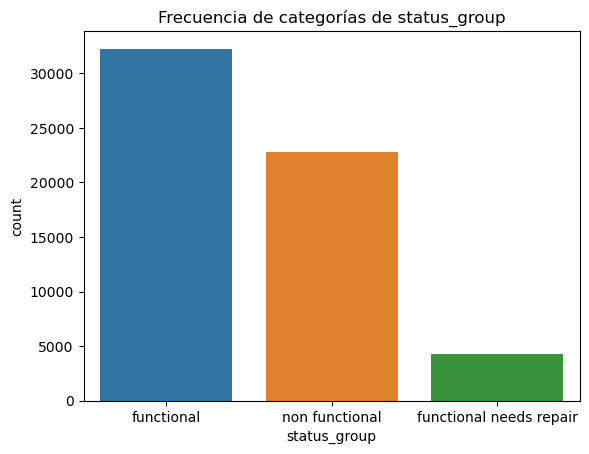

In [8]:
# Grafico frecuencia de variable a predecir y veo que no hay un balanceo, la categóría 'functional needs repair' esta muy por
# debajo de las demás. Más adelante tratare de hacer un pequeño balanceo.

sns.countplot(x='status_group', data=data)
plt.title('Frecuencia de categorías de status_group')
plt.show()

In [9]:
# Creo una copia de test_set_values, para ir depurando los datos de prueba en conjunto con los datos de entrenamiento.

data_test = test_set_values.copy()

In [10]:
data_test.shape

(14850, 40)

In [11]:
# Codifico la variable a predecir con Label Encoder.

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['status_group'] = label_encoder.fit_transform(data['status_group'])


In [12]:
data['status_group'].unique()

array([0, 2, 1])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [14]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [15]:
# Separo en columnas categóricas y númericas para tranajar nulos.

cat_cols= data.select_dtypes(include=['object','category']).columns
num_cols = data.select_dtypes(exclude=['object','category']).columns

In [16]:
cat_cols_test= data_test.select_dtypes(include=['object','category']).columns
num_cols_test = data_test.select_dtypes(exclude=['object','category']).columns

In [17]:
# Veo los valores únicos para las columnas categóricas y booleanas en el conjunto data.

data.select_dtypes(exclude='number').nunique()

date_recorded              356
funder                    1896
installer                 2145
wpt_name                 37399
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2695
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [18]:
# Hago lo mismo para data_test.

data_test.select_dtypes(exclude='number').nunique()

date_recorded              331
funder                     979
installer                 1091
wpt_name                 10840
basin                        9
subvillage                8443
region                      21
lga                        125
ward                      1959
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               1788
permit                       2
extraction_type             17
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

# Variables Categóricas

### Tratamiento nulos y descarte de variables

In [19]:
# Analizo cuales columnas categóricas tienen valores nulos.

def contar_nulos(dataset, num_cols, cat_cols):

    # Calcular la cantidad de valores nulos en columnas numéricas
    num_nulos = dataset[num_cols].isnull().sum()
    num_nulos = num_nulos[num_nulos > 0]  # Filtrar para mostrar solo los valores mayores que 0

    # Calcular la cantidad de valores nulos en columnas categóricas
    cat_nulos = dataset[cat_cols].isnull().sum()
    cat_nulos = cat_nulos[cat_nulos > 0]  # Filtrar para mostrar solo los valores mayores que 0

    # Verificar si no hay valores nulos y devolver un mensaje apropiado
    if num_nulos.empty:
        print("No hay valores nulos en las variables numéricas.")
    else:
        print('Si hay valores nulos en las variables numéricas.')

    if cat_nulos.empty:
        print("No hay valores nulos en las variables categóricas.")
    else:
        print('Si hay valores nulos en las variables categóricas.')

    return num_nulos, cat_nulos


In [20]:
# Para data:
contar_nulos(data, num_cols, cat_cols)


No hay valores nulos en las variables numéricas.
Si hay valores nulos en las variables categóricas.


(Series([], dtype: int64),
 funder                3637
 installer             3655
 wpt_name                 2
 subvillage             371
 public_meeting        3334
 scheme_management     3878
 scheme_name          28810
 permit                3056
 dtype: int64)

In [21]:
# Para data_test:
contar_nulos(data_test, num_cols_test, cat_cols_test)

No hay valores nulos en las variables numéricas.
Si hay valores nulos en las variables categóricas.


(Series([], dtype: int64),
 funder                870
 installer             877
 subvillage             99
 public_meeting        821
 scheme_management     969
 scheme_name          7242
 permit                737
 dtype: int64)

In [22]:
#Analizo los porcentajes de los valores nulos

def contar_nulos_pct(dataset, num_cols, cat_cols):
    
    # Calcular la cantidad de valores nulos en columnas numéricas
    num_nulos = dataset[num_cols].isnull().sum()
    num_nulos = num_nulos[num_nulos > 0]/len(dataset)*100  # Filtrar para mostrar solo los valores mayores que 0

    # Calcular la cantidad de valores nulos en columnas categóricas
    cat_nulos = dataset[cat_cols].isnull().sum()
    cat_nulos = cat_nulos[cat_nulos > 0]/len(dataset)*100   # Filtrar para mostrar solo los valores mayores que 0

    # Verificar si no hay valores nulos y devolver un mensaje apropiado
    if num_nulos.empty:
        print("No hay valores nulos en las variables numéricas.")
    else:
        print('Si hay valores nulos en las variables numéricas.')

    if cat_nulos.empty:
        print("No hay valores nulos en las variables categóricas.")
    else:
        print('Si hay valores nulos en las variables categóricas.')

    return num_nulos, cat_nulos

In [23]:
# Para data:

contar_nulos_pct(data, num_cols, cat_cols)

No hay valores nulos en las variables numéricas.
Si hay valores nulos en las variables categóricas.


(Series([], dtype: float64),
 funder                6.122896
 installer             6.153199
 wpt_name              0.003367
 subvillage            0.624579
 public_meeting        5.612795
 scheme_management     6.528620
 scheme_name          48.501684
 permit                5.144781
 dtype: float64)

In [24]:
# Para data_test:

contar_nulos_pct(data_test, num_cols_test, cat_cols_test)

No hay valores nulos en las variables numéricas.
Si hay valores nulos en las variables categóricas.


(Series([], dtype: float64),
 funder                5.858586
 installer             5.905724
 subvillage            0.666667
 public_meeting        5.528620
 scheme_management     6.525253
 scheme_name          48.767677
 permit                4.962963
 dtype: float64)

Son pocas las variables categóricas con valores nulos y, al menos a simple vista, las númericas no tienen nulos. Seguiremos analizando una a una para ver que no exista un valor que represente valores nulos, por ejemplo 0. Además, tambien podemos observar que la columna 'scheme_name' cuenta con una gran cantidad de nulos.

#### Variable 'scheme_name'

In [25]:
#Contiene 2695 de valores únicos, no muy buen indicio para utilizarlo como factor.

data['scheme_name'].describe()

count     30590
unique     2695
top           K
freq        682
Name: scheme_name, dtype: object

In [26]:
# Pense en dejar las 5 principales categorías y agrupar las demás en 'Otros', pero entre las primeras 5 no suma una cantidad
# significa de registros de esta variable. Por lo que descarto esa idea.

data['scheme_name'].value_counts()

scheme_name
K                       682
Borehole                546
Chalinze wate           405
M                       400
DANIDA                  379
                       ... 
Mradi wa maji Vijini      1
Villagers                 1
Magundi water supply      1
Saadani Chumv             1
Mtawanya                  1
Name: count, Length: 2695, dtype: int64

In [27]:
# Decido eliminar la columna 'scheme_name' ya que cumple el mismo propósito que 'scheme_management' y además tiene un 48%
# de valores faltantes y cuenta con 2695 valores únicos.

data = data.drop(columns = ['scheme_name'])

In [28]:
# Lo mismo hago con data_test:

data_test = data_test.drop(columns = ['scheme_name'])

#### Variable 'funder'

In [29]:
# Si bien esta variable parece que no tuviera que ver con el problema, se me ocurre que tal vez el mantenimiento del sistema de 
# agua pueda variar dependiendo quien invirtio en el. Por lo que tratare de trabajar la variable y no eliminarla aunqnue tenga
# una gran cantidad de valores únicos.

data['funder'].describe()

count                      55763
unique                      1896
top       Government Of Tanzania
freq                        9084
Name: funder, dtype: object

In [30]:
data['funder'].value_counts()

funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Muwasa                       1
Msigw                        1
Rc Mofu                      1
Overland High School         1
Samlo                        1
Name: count, Length: 1896, dtype: int64

In [31]:
# Calculo la suma de las 9 categorías más repetidas con el objetivo de ver si es una cantidad representativa.

data['funder'].value_counts().head(9).sum()

21590

In [32]:
# Esta función la termine de crear con ayuda de Chat GPT.

def reducir_categorias(data, cat_col, top_n_col):
    """
    Agrupa las categorías menos comunes en 'Other' en las columnas especificadas de un DataFrame.
    
    Parámetros:
    data (DataFrame): El DataFrame donde se encuentran las columnas.
    cat_cols (list): La lista de nombres de columnas que se van a procesar.
    top_n (int): El número de categorías más comunes que se van a conservar.

    Retorna:
    DataFrame: El DataFrame con las categorías menos comunes reemplazadas por 'Other' en las columnas especificadas.
    """
    for columna in cat_cols:
        # Calcular las frecuencias de cada categoría
        frecuencias = data[cat_col].value_counts()
        
        # Seleccionar las N categorías más comunes
        principales = frecuencias.head(top_n_col).index
        
        # Crear una máscara booleana
        mask = ~data[cat_col].isin(principales)
        
        # Reemplazar las categorías menos comunes con 'Other'
        data.loc[mask, cat_col] = 'Other'
    
    return data[cat_col].value_counts()

In [33]:
# Modifico la variable 'funder', me quedo con las primeras 9 categorías más repetidas y asigno 'Other' a los demás, 
# incluyendo a los nulos.

reducir_categorias(data, 'funder', 10)

funder
Other                     37810
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
Name: count, dtype: int64

In [34]:
# Verifico que hayan quedado 9 categorías + 'Other'

data['funder'].value_counts()

funder
Other                     37810
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
Name: count, dtype: int64

In [35]:
# Verifico que no tenga nulos.

data['funder'].isnull().sum()

0

In [36]:
# Reduzco para data_test:

reducir_categorias(data_test, 'funder', 10)

funder
Other                     9403
Government Of Tanzania    2215
Danida                     793
Hesawa                     580
World Bank                 352
Kkkt                       336
Rwssp                      329
World Vision               316
Unicef                     267
Tasaf                      259
Name: count, dtype: int64

#### Variable 'installer'

Esta variable la voy a tratar de la misma forma que 'funder'. Creo que quien instalo el sistema de agua, podría estar relacionado con su condición. 

In [37]:
# Tiene un gran número de valores únicos, por lo que es dificil utilizarla sin modificarla. 

data['installer'].describe()

count     55745
unique     2145
top         DWE
freq      17402
Name: installer, dtype: object

In [38]:
data['installer'].value_counts()

installer
DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: count, Length: 2145, dtype: int64

In [39]:
# La suma de los 9 primeros registros es una cantidad considerable.

data['installer'].value_counts().head(7).sum()

24281

In [40]:
# Realizo lo mismo que hice para 'funder', pero en este caso serán las 7 categorías más repetidas y creare 'Other' par el resto.
# Decido 7 categorías ya que uno de las categorías es llamada '0' y parece estar siendo utilizado como 'Unknown'.

reducir_categorias(data, 'installer', 8)


installer
Other         35119
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
KKKT            898
Hesawa          840
Name: count, dtype: int64

In [41]:
data['installer'].isnull().sum()

0

In [42]:
# Lo mismo para data_test:

reducir_categorias(data_test, 'installer', 8)

installer
Other         8758
DWE           4349
Government     457
RWE            292
Commu          287
DANIDA         255
Hesawa         230
KKKT           222
Name: count, dtype: int64

In [43]:
data_test['installer'].isnull().sum()

0

#### Variable 'wpt_name'

Esta variable decido eliminarla directamente, creo que no tiene ninguna relacion con la solución del problema, es el nombre del sistema de agua.

In [44]:
data = data.drop(columns=['wpt_name'])

In [45]:
data_test = data_test.drop(columns=['wpt_name'])

#### Variable 'subvillage'

In [46]:
# Podemos ver que esta variable presenta una gran granularidad con un monto de 19287 valores únicos.

data['subvillage'].describe()

count        59029
unique       19287
top       Madukani
freq           508
Name: subvillage, dtype: object

In [47]:
# Esta variable no podré trabajarla de la misma forma que 'funder' e 'installer' ya que la suma de las primeras 10 categorías
# no es para nada una cantidad representativa del total de de la columna. Además el dataset ya presenta otras variables que 
# trabajan la ubicación de los sistemas de agua.

data['subvillage'].value_counts().head(40)

subvillage
Madukani                508
Shuleni                 506
Majengo                 502
Kati                    373
Mtakuja                 262
Sokoni                  232
M                       187
Muungano                172
Mbuyuni                 164
Mlimani                 152
Songambele              147
Msikitini               134
Miembeni                134
1                       132
Kibaoni                 114
Kanisani                111
I                       109
Mapinduzi               109
Mjimwema                108
Mjini                   108
Mkwajuni                104
Mwenge                  102
Mabatini                 98
Azimio                   98
Mission                  95
Mbugani                  95
Bwawani                  91
Bondeni                  90
Chang'Ombe               88
Zahanati                 86
Senta                    84
Mtaa Wa Kitunda Kati     84
Kichangani               84
Misufini                 83
Center                   82
Nyerere  

In [48]:
data['subvillage'].isnull().sum()

371

In [49]:
#Decido eliminar esta variable por los motivos mencionados anteriormente. 

data = data.drop(columns=['subvillage'])

In [50]:
data_test = data_test.drop(columns=['subvillage'])

 #### Variable 'public_meeting'

In [51]:
# En el problema no describe claramente cual es el significado de esta variable, puedo interpretarlo como si se hizo una
# reunion del pueblo/ciudad para consenzuar el sistema de agua. 

# Al ser un a variable booleana y con menos del 10% de valores nulos, me la quedare para ver más adelante si tiene alguna
# relacion con la variable a predecir.

data['public_meeting'].describe()

count     56066
unique        2
top        True
freq      51011
Name: public_meeting, dtype: object

In [52]:
data['public_meeting'].value_counts()

public_meeting
True     51011
False     5055
Name: count, dtype: int64

In [53]:
data['public_meeting'].isnull().sum()

3334

In [54]:
# Imputo los null por la moda.

data['public_meeting'] = data['public_meeting'].fillna(data['public_meeting'].mode()[0])

In [55]:
data['public_meeting'].isnull().sum()

0

In [56]:
# Hago lo mismo para data_test:

data_test['public_meeting'] = data_test['public_meeting'].fillna(data_test['public_meeting'].mode()[0])

#### Variable 'scheme_management'

In [57]:
# Esta variable puede estar directamente relacionada con la variable a predecir. Tiene solamente 11 valores únicos, y 3878
# valores nulos. Lo que hare es analizar los 11 valores únicos y luego imputar por moda.

data['scheme_management'].describe()

count     55522
unique       11
top         VWC
freq      36793
Name: scheme_management, dtype: object

In [58]:
data['scheme_management'].value_counts()

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

In [59]:
data['scheme_management'].isnull().sum()

3878

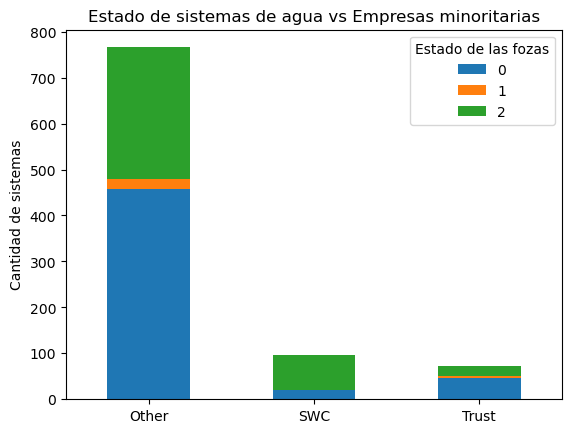

In [60]:
# Filtrar el DataFrame para incluir solo las empresas 'Other', 'SWC' y 'Trust'
empresas_minoritarias = ['Other', 'SWC', 'Trust']
df = data[data['scheme_management'].isin(empresas_minoritarias)]

# Calcular la tabla de contingencia para las empresas seleccionadas
contingency_table = pd.crosstab(df['scheme_management'], df['status_group'])

# Graficar el gráfico de barras apiladas
contingency_table.plot(kind='bar', stacked=True)
plt.title('Estado de sistemas de agua vs Empresas minoritarias')
plt.xlabel('')
plt.ylabel('Cantidad de sistemas')
plt.xticks(rotation=0)
plt.legend(title='Estado de las fozas')
plt.show()

In [61]:
# Para tener 10 categorías dentro de esta variable, incluire 'Trust' dentro de others y los nulos los imputare por la moda.

data['scheme_management'] = data['scheme_management'].replace('SWC', 'Other')

In [62]:
data['scheme_management'] = data['scheme_management'].fillna(data['scheme_management'].mode()[0])

In [63]:
data['scheme_management'].value_counts()

scheme_management
VWC                 40671
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 863
Trust                  72
Name: count, dtype: int64

In [64]:
data['scheme_management'].isnull().sum()

0

In [65]:
# Lo mismo para data_test:

data_test['scheme_management'] = data_test['scheme_management'].replace('SWC', 'Other')

In [66]:
data_test['scheme_management'] = data_test['scheme_management'].fillna(data_test['scheme_management'].mode()[0])

#### Variable 'permit'

En primer instancia creo que esta variable podria estar relacionada con la variable a predecir, ya que puede ser que si es un sistema permitido tenga más mantenimiento que uno no permitido. Además es una variable booleana que es bueno conservar, imputare los nulos por la moda.

In [67]:
data['permit'].describe()

count     56344
unique        2
top        True
freq      38852
Name: permit, dtype: object

In [68]:
data['permit'].value_counts()

permit
True     38852
False    17492
Name: count, dtype: int64

In [69]:
# Imputo faltantes por la moda.

data['permit'] = data['permit'].fillna(data['permit'].mode()[0])

In [70]:
data['permit'].isnull().sum()

0

In [71]:
# Lo mismo para data_test:

data_test['permit'] = data_test['permit'].fillna(data_test['permit'].mode()[0])

In [72]:
# Corroboro que me haya quedado sin nulos

data_test['permit'].isnull().sum()

0

#### Variable 'basin'

In [73]:
# Creo que esta puede ser una muy buena variable de localización. Solamente tiene 9 registros para las fuentes de agua que 
# alimentan los sistemas. No tiene nulos a tratar.

data['basin'].describe()

count             59400
unique                9
top       Lake Victoria
freq              10248
Name: basin, dtype: object

In [74]:
data['basin'].value_counts()

basin
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: count, dtype: int64

In [75]:
data_test['basin'].describe()

count             14850
unique                9
top       Lake Victoria
freq               2623
Name: basin, dtype: object

#### Variable 'region' y 'region_code'

Dos variables que son muy similares, donde 'region_code' parece ser la codificación de 'region'.

In [76]:
data['region'].describe()

count      59400
unique        21
top       Iringa
freq        5294
Name: region, dtype: object

In [77]:
data['region'].value_counts()

region
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: count, dtype: int64

In [78]:
data['region'].value_counts().head(9).sum()

35884

In [79]:
data['region_code'].nunique()

27

In [80]:
data['region_code'].value_counts()

region_code
11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: count, dtype: int64

In [81]:
# Existen diferencias entre las dos variables, una contiene 21 categorías mientras la otra cuenta con 27. Eliminare la variable
# codificada y me quedare con 'region', que luego codificaré.

data = data.drop(columns=['region_code'])

In [82]:
# Elimino tambien para data_test:

data_test = data_test.drop(columns=['region_code'])

In [83]:
# Reduzco categorías de region a 9

reducir_categorias(data,'region',9)

region
Other          26332
Iringa          5294
Shinyanga       4982
Mbeya           4639
Kilimanjaro     4379
Morogoro        4006
Arusha          3350
Kagera          3316
Mwanza          3102
Name: count, dtype: int64

In [84]:
# Aplico la función para data_test.

reducir_categorias(data_test, 'region', 9)

region
Other          6554
Shinyanga      1311
Iringa         1305
Mbeya          1119
Kilimanjaro    1115
Morogoro       1032
Kagera          858
Mwanza          795
Arusha          761
Name: count, dtype: int64

#### Variable 'recorded_by'

In [85]:
data['recorded_by'].describe()

count                       59400
unique                          1
top       GeoData Consultants Ltd
freq                        59400
Name: recorded_by, dtype: object

In [86]:
# Es una variable constante con un único registro, no tiene sentido asi que será eliminada.

data = data.drop(columns = 'recorded_by')

In [87]:
data_test = data_test.drop(columns = 'recorded_by')

#### Variable 'extraction_type', 'extraction_type_group', 'extraction_type_class'

In [88]:
data['extraction_type'].describe()

count       59400
unique         18
top       gravity
freq        26780
Name: extraction_type, dtype: object

In [89]:
data['extraction_type_group'].describe()

count       59400
unique         13
top       gravity
freq        26780
Name: extraction_type_group, dtype: object

In [90]:
data['extraction_type_class'].describe()

count       59400
unique          7
top       gravity
freq        26780
Name: extraction_type_class, dtype: object

In [91]:
data['extraction_type'].value_counts()

extraction_type
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: count, dtype: int64

In [92]:
data['extraction_type_group'].value_counts()

extraction_type_group
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: count, dtype: int64

In [93]:
data['extraction_type_class'].value_counts()

extraction_type_class
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: count, dtype: int64

In [94]:
# Parece ser que contienen la misma información pero 'extraction_typle_class' es la que contiene menos detalle y agrupa
# los tipos de extracción en clases. Solamente tiene 7 categorías, por lo que me quedare con esta variable.

data = data.drop(columns=['extraction_type_group', 'extraction_type'])

In [95]:
data_test = data_test.drop(columns=['extraction_type_group', 'extraction_type'])

#### Variable 'management' y 'management_group'

In [96]:
data['management'].describe()

count     59400
unique       12
top         vwc
freq      40507
Name: management, dtype: object

In [97]:
data['management_group'].describe()

count          59400
unique             5
top       user-group
freq           52490
Name: management_group, dtype: object

In [98]:
data['management'].value_counts()

management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: count, dtype: int64

In [99]:
data['management_group'].value_counts()

management_group
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: count, dtype: int64

In [100]:
# Dado que ambas variables tienen pocos valores únicos, las trabajare para conservar las dos.
# Por un lado, en 'management', remplazare los valores de 'trust', 'other - school' y 'unknown' por 'other'.

data['management'] = data['management'].replace({'trust' : 'other', 'other - school' : 'other', 'unknown' : 'other'})

In [101]:
# Por otro lado, en 'management_group' haré algo similar, remplazando unknown por other.

data['management_group'] = data['management_group'].replace('unknown', 'other')

In [102]:
data_test['management'] = data_test['management'].replace({'trust' : 'other', 'other - school' : 'other', 'unknown' : 'other'})

In [103]:
data_test['management_group'] = data_test['management_group'].replace('unknown', 'other')

#### Variable 'payment' y 'payment_type'

In [104]:
data['payment'].describe()

count         59400
unique            7
top       never pay
freq          25348
Name: payment, dtype: object

In [105]:
data['payment'].value_counts()

payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: count, dtype: int64

In [106]:
data['payment_type'].describe()

count         59400
unique            7
top       never pay
freq          25348
Name: payment_type, dtype: object

In [107]:
data['payment_type'].value_counts()

payment_type
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: count, dtype: int64

In [108]:
# Podemos ver que ambas variables representan lo mismo, tienen el mismo número de registros y que las categorías son las mismas
# con palabras difetentes. Me quedaré con 'payment_type' y eliminaré 'payment'.

data = data.drop(columns = 'payment')

In [109]:
# En 'payment_type', remplazare los valores 'unknown' por 'other'.

data['payment_type'] = data['payment_type'].replace('unknown', 'other')

In [110]:
data_test = data_test.drop(columns = 'payment')

In [111]:
data_test['payment_type'] = data_test['payment_type'].replace('unknown', 'other')

#### Variable 'water_quality' y 'quality_group'

In [112]:
data['water_quality'].describe()

count     59400
unique        8
top        soft
freq      50818
Name: water_quality, dtype: object

In [113]:
data['water_quality'].value_counts()

water_quality
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: count, dtype: int64

In [114]:
data['quality_group'].describe()

count     59400
unique        6
top        good
freq      50818
Name: quality_group, dtype: object

In [115]:
data['quality_group'].value_counts()

quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: count, dtype: int64

In [116]:
# Parece ser que las variables son muy similares, la variable 'quality_group' agrupa dos categorías de 'water_quality'.
# Me quedare con 'quality_group'.

data = data.drop(columns='water_quality')

In [117]:
data_test = data_test.drop(columns='water_quality')

#### Variable 'quantity' y 'quantity_group'

In [118]:
data['quantity_group'].describe()

count      59400
unique         5
top       enough
freq       33186
Name: quantity_group, dtype: object

In [119]:
data['quantity_group'].value_counts()

quantity_group
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

In [120]:
data['quantity'].describe()

count      59400
unique         5
top       enough
freq       33186
Name: quantity, dtype: object

In [121]:
data['quantity'].value_counts()

quantity
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

In [122]:
# Se repite la información, me quedo con 'quantity_group'.

data = data.drop(columns='quantity')

In [123]:
data_test = data_test.drop(columns='quantity')

#### Variable 'source', 'source_type', 'source_class'

In [124]:
data['source'].describe()

count      59400
unique        10
top       spring
freq       17021
Name: source, dtype: object

In [125]:
data['source_type'].describe()

count      59400
unique         7
top       spring
freq       17021
Name: source_type, dtype: object

In [126]:
data['source_class'].describe()

count           59400
unique              3
top       groundwater
freq            45794
Name: source_class, dtype: object

In [127]:
data['source'].value_counts()

source
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: count, dtype: int64

In [128]:
data['source_type'].value_counts()

source_type
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: count, dtype: int64

In [129]:
data['source_class'].value_counts()

source_class
groundwater    45794
surface        13328
unknown          278
Name: count, dtype: int64

In [130]:
# Nuevamente las variables son muy similares, apuntando hacia una menor dimensionalidad y evitar la multicolinealidad en el caso
# de las regresiones, me quedare con 'source_type'.

data = data.drop(columns=['source_class', 'source'])

In [131]:
data_test = data_test.drop(columns=['source_class', 'source'])

#### Variable 'waterpoint_type' y 'waterpoint_type_group'

In [132]:
data['waterpoint_type'].describe()

count                  59400
unique                     7
top       communal standpipe
freq                   28522
Name: waterpoint_type, dtype: object

In [133]:
data['waterpoint_type_group'].describe()

count                  59400
unique                     6
top       communal standpipe
freq                   34625
Name: waterpoint_type_group, dtype: object

In [134]:
data['waterpoint_type'].value_counts()

waterpoint_type
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: count, dtype: int64

In [135]:
data['waterpoint_type_group'].value_counts()

waterpoint_type_group
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: count, dtype: int64

In [136]:
# Sucede lo mismo que en en las variables trabajadas anteriormente, la información es muy similar. Me quedaré con 
# 'waterpoint_type_group'

data = data.drop(columns='waterpoint_type')


In [137]:
data_test = data_test.drop(columns='waterpoint_type')

In [138]:
data.shape

(59400, 28)

#### Codifico las variables booleanas en 1 y 0.

In [139]:
data['public_meeting'] = data['public_meeting'].astype('int64')

In [140]:
data['public_meeting'].value_counts()

public_meeting
1    54345
0     5055
Name: count, dtype: int64

In [141]:
data['permit'] = data['permit'].astype('int64')

In [142]:
data['permit'].value_counts()

permit
1    41908
0    17492
Name: count, dtype: int64

In [143]:
data_test['public_meeting'] = data_test['public_meeting'].astype('int64')

In [144]:
data_test['public_meeting'].value_counts()

public_meeting
1    13559
0     1291
Name: count, dtype: int64

In [145]:
data_test['permit'] = data_test['permit'].astype('int64')

In [146]:
data_test['permit'].value_counts()

permit
1    10491
0     4359
Name: count, dtype: int64

#### Cambio el tipo de variable de 'object' a 'category' en las variables categóricas

In [147]:
cat_cols2 = ['funder', 'installer', 'basin', 'region', 'scheme_management', 'extraction_type_class', 'management', 'management_group',
            'payment_type', 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group', 'ward']

In [148]:
data[cat_cols2] = data[cat_cols2].astype('category')


In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     59400 non-null  int64   
 1   amount_tsh             59400 non-null  float64 
 2   date_recorded          59400 non-null  object  
 3   funder                 59400 non-null  category
 4   gps_height             59400 non-null  int64   
 5   installer              59400 non-null  category
 6   longitude              59400 non-null  float64 
 7   latitude               59400 non-null  float64 
 8   num_private            59400 non-null  int64   
 9   basin                  59400 non-null  category
 10  region                 59400 non-null  category
 11  district_code          59400 non-null  int64   
 12  lga                    59400 non-null  object  
 13  ward                   59400 non-null  category
 14  population             59400 non-null 

In [150]:
data_test[cat_cols2] = data_test[cat_cols2].astype('category')

In [151]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     14850 non-null  int64   
 1   amount_tsh             14850 non-null  float64 
 2   date_recorded          14850 non-null  object  
 3   funder                 14850 non-null  category
 4   gps_height             14850 non-null  int64   
 5   installer              14850 non-null  category
 6   longitude              14850 non-null  float64 
 7   latitude               14850 non-null  float64 
 8   num_private            14850 non-null  int64   
 9   basin                  14850 non-null  category
 10  region                 14850 non-null  category
 11  district_code          14850 non-null  int64   
 12  lga                    14850 non-null  object  
 13  ward                   14850 non-null  category
 14  population             14850 non-null 

## Variables numéricas

#### Variable 'date_recorded'

Trato esta variable de la misma forma que lo hicimos en el ejercicio en clase. Paso la columna 'date_recorded' a tipo datetime y resto la fecha mas actual de la varaible por las fechas de la variable para analizar la antiguedad en días.

In [152]:
data['date_recorded'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: date_recorded
Non-Null Count  Dtype 
--------------  ----- 
59400 non-null  object
dtypes: object(1)
memory usage: 464.2+ KB


In [153]:
data['date_recorded'] = pd.to_datetime(data['date_recorded'])

In [154]:
data['date_recorded'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: date_recorded
Non-Null Count  Dtype         
--------------  -----         
59400 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 464.2 KB


In [155]:
data['date_recorded'].describe()

count                            59400
mean     2012-03-29 09:11:33.818181888
min                2002-10-14 00:00:00
25%                2011-04-01 00:00:00
50%                2012-10-10 00:00:00
75%                2013-02-09 00:00:00
max                2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [156]:
data['date_recorded'] = (pd.to_datetime('2013-12-03') - data['date_recorded']).dt.days

In [157]:
data['date_recorded']

0         995
1         272
2         281
3         309
4         874
         ... 
59395     214
59396     941
59397     967
59398    1001
59399     986
Name: date_recorded, Length: 59400, dtype: int64

In [158]:
data_test['date_recorded'] = pd.to_datetime(data_test['date_recorded'])

In [159]:
data_test['date_recorded'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14850 entries, 0 to 14849
Series name: date_recorded
Non-Null Count  Dtype         
--------------  -----         
14850 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 116.1 KB


In [160]:
data_test['date_recorded'] = (pd.to_datetime('2013-12-03') - data_test['date_recorded']).dt.days

In [161]:
data_test['date_recorded'].value_counts()

date_recorded
303     138
993     137
992     137
991     130
995     129
       ... 
801       1
3621      1
331       1
823       1
3616      1
Name: count, Length: 331, dtype: int64

#### Variable 'longitude' y 'latitude'

Estas son variables de localización, en el dataset hay más que cumplen la misma o similar función. De todas formas analizare e intentare conservarlas.

In [162]:
# Chequeo el tipo de dato, ya que deben estan en float.

data[['longitude', 'latitude']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  59400 non-null  float64
 1   latitude   59400 non-null  float64
dtypes: float64(2)
memory usage: 928.3 KB


In [163]:
# Algo que me llama la atencion es y es que hay 1812 registros con longitud 0 y latitud -0,00000002.
# Entiendo que esto puede ser debido a que no hay información acerca de su latitud y longitud, por lo que debere trabajar estos
# números o descartar esta variable para mi modelo.

data[['longitude', 'latitude']].value_counts()

longitude  latitude     
0.000000   -2.000000e-08    1812
39.096123  -6.975052e+00       2
37.534327  -6.964258e+00       2
39.095684  -6.992611e+00       2
39.095087  -6.983115e+00       2
                            ... 
33.876579  -3.087198e+00       1
33.876644  -9.441951e+00       1
33.876800  -9.584327e+00       1
33.876925  -9.310372e+00       1
40.345193  -1.049578e+01       1
Name: count, Length: 57520, dtype: int64

In [164]:
# Teniendo en cuenta los limites coordinales de Tanzania, utilizo esta funcion para encontrar las longitudes por fuera
# de los parametros de Tanzania.

# Definir los límites de latitud y longitud de Tanzania
lon_min, lon_max = 29, 41

# Filtrar los datos para encontrar las latitudes y longitudes fuera de los límites de Tanzania
longitudes_fuera = data[(data['longitude'] < lon_min) | (data['longitude'] > lon_max)]

# Imprimir los resultados
print("\nLongitudes fuera de Tanzania:")
print(longitudes_fuera['longitude'])



Longitudes fuera de Tanzania:
21       0.0
53       0.0
168      0.0
177      0.0
253      0.0
        ... 
59189    0.0
59208    0.0
59295    0.0
59324    0.0
59374    0.0
Name: longitude, Length: 1812, dtype: float64


In [165]:
# Realizo lo mismo pero para la latitud,

# Definir los límites de latitud de Tanzania
lat_min, lat_max = -12, -1

# Filtrar los datos para encontrar las latitudes fuera de los límites de Tanzania
latitudes_fuera = data[(data['latitude'] < lat_min) | (data['latitude'] > lat_max)]

# Imprimir las latitudes fuera de Tanzania
print("Latitudes fuera de Tanzania:")
print(latitudes_fuera['latitude'])


Latitudes fuera de Tanzania:
21      -2.000000e-08
53      -2.000000e-08
168     -2.000000e-08
177     -2.000000e-08
253     -2.000000e-08
             ...     
59189   -2.000000e-08
59208   -2.000000e-08
59295   -2.000000e-08
59324   -2.000000e-08
59374   -2.000000e-08
Name: latitude, Length: 1819, dtype: float64


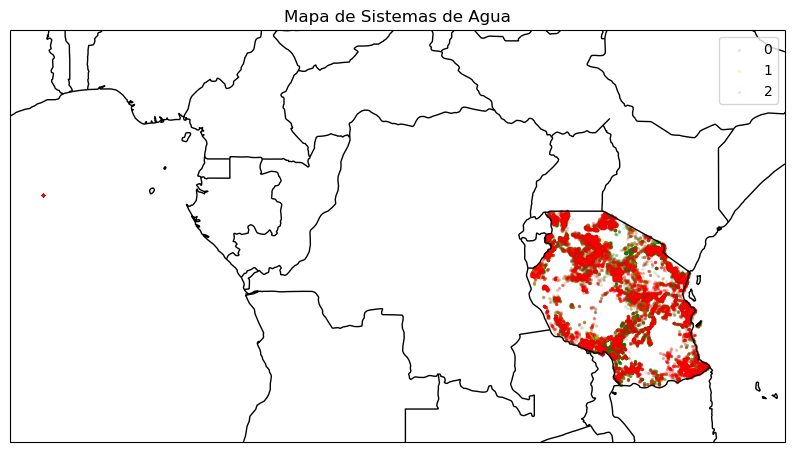

In [166]:
# Encontre esta librería que permite graficar mapas y con ayuda de la longitud y latitud marcar donde estan los sistemas de
# agua en Tanzania.

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Diccionario de colores para cada categoría de 'status_group'
color_map = {0: 'g', 1: 'y', 2: 'r'}  # Green, Yellow, Red para functional, functional needs repair, non functional respectivamente

# Crear una figura y ejes con un tamaño personalizado
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Establecer límites de los ejes para abarcar la región de África
ax.set_extent([-2, 45, -15, 10], crs=ccrs.PlateCarree())  # longitud mínima, longitud máxima, latitud mínima, latitud máxima

# Agregar contornos de costas
ax.coastlines()

# Agregar contornos de países
ax.add_feature(cfeature.BORDERS)

# Iterar sobre cada categoría y agregar marcadores con el color correspondiente y transparencia
for status, color in color_map.items():
    subset = data[data['status_group'] == status]
    ax.scatter(subset['longitude'], subset['latitude'], color=color, marker='o', label=status, transform=ccrs.PlateCarree(), alpha=0.1, s=2)

# Agregar título y leyenda
ax.set_title('Mapa de Sistemas de Agua')
ax.legend()

# Mostrar el mapa
plt.show()



Al ver que hay un punto que se encuentra por fuera de Tanzania, debo imputarlo. Cabe destacar que para ver ese punto, comence por relizar un mapa que incluía al continente africano en su totalidad y de esa forma descubri que habia algunas coordenadas erroneas. Además, con el codigo anterior tambien descubro los puntos que estan por fuera.

In [167]:
data['latitude'].nlargest(10)

21    -2.000000e-08
53    -2.000000e-08
168   -2.000000e-08
177   -2.000000e-08
253   -2.000000e-08
256   -2.000000e-08
285   -2.000000e-08
301   -2.000000e-08
306   -2.000000e-08
321   -2.000000e-08
Name: latitude, dtype: float64

In [168]:
data['longitude'].nlargest(10)

735      40.345193
54030    40.344301
32602    40.325240
42877    40.325226
32185    40.323402
30137    40.322832
31178    40.322805
35616    40.322625
45651    40.322169
8685     40.321966
Name: longitude, dtype: float64

In [169]:
# Imputo los valores fuera del territorio de Tanzania utilizando 'region' como referencia.

# Calcular la mediana de longitud para cada región
median_longitudes = data.groupby('region')['longitude'].median()

# Imputar la mediana de longitud para los valores de longitud iguales a 0.0
for index, row in data.iterrows():
    if np.isclose(row['longitude'], 0.0):  # Comprobamos si el valor es cercano a 0.0 para evitar problemas con valores que puedan ser ligeramente diferentes debido a errores de punto flotante.
        region = row['region']
        median_longitude = median_longitudes.get(region)  # Obtenemos la mediana de longitud de la región
        if median_longitude is not None:  # Verificamos si se encontró una mediana válida
            data.at[index, 'longitude'] = median_longitude

# Ahora los valores de longitud incorrectos (0.0) se han imputado con la mediana de longitud correspondiente a su región.

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_16912\2786041737.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_longitudes = data.groupby('region')['longitude'].median()


In [170]:
# Lo mismo para data_test

# Calcular la mediana de longitud para cada región
median_longitudes = data_test.groupby('region')['longitude'].median()

# Imputar la mediana de longitud para los valores de longitud iguales a 0.0
for index, row in data_test.iterrows():
    if np.isclose(row['longitude'], 0.0):  # Comprobamos si el valor es cercano a 0.0 para evitar problemas con valores que puedan ser ligeramente diferentes debido a errores de punto flotante.
        region = row['region']
        median_longitude = median_longitudes.get(region)  # Obtenemos la mediana de longitud de la región
        if median_longitude is not None:  # Verificamos si se encontró una mediana válida
            data_test.at[index, 'longitude'] = median_longitude

# Ahora los valores de longitud incorrectos (0.0) se han imputado con la mediana de longitud correspondiente a su región.

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_16912\264224694.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_longitudes = data_test.groupby('region')['longitude'].median()


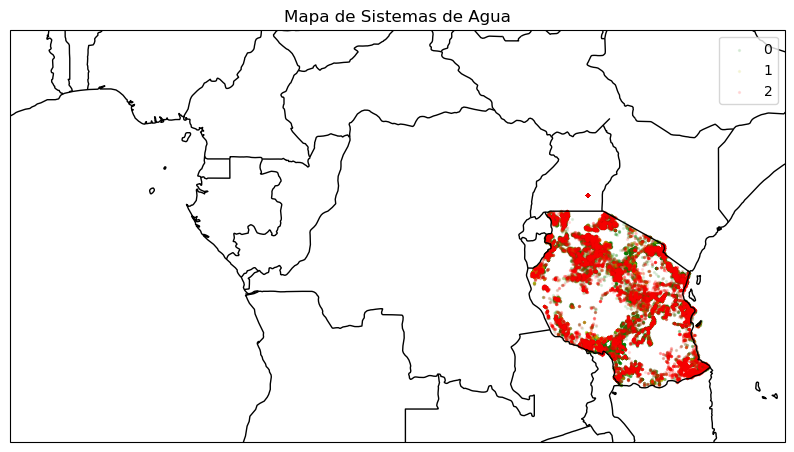

In [171]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Diccionario de colores para cada categoría de 'status_group'
color_map = {0: 'g', 1: 'y', 2: 'r'}  # Green, Yellow, Red para functional, functional needs repair, non functional respectivamente

# Crear una figura y ejes con un tamaño personalizado
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Establecer límites de los ejes para abarcar la región de África
ax.set_extent([-2, 45, -15, 10], crs=ccrs.PlateCarree())  # longitud mínima, longitud máxima, latitud mínima, latitud máxima

# Agregar contornos de costas
ax.coastlines()

# Agregar contornos de países
ax.add_feature(cfeature.BORDERS)

# Iterar sobre cada categoría y agregar marcadores con el color correspondiente y transparencia
for status, color in color_map.items():
    subset = data[data['status_group'] == status]
    ax.scatter(subset['longitude'], subset['latitude'], color=color, marker='o', label=status, transform=ccrs.PlateCarree(), alpha=0.1, s=2)

# Agregar título y leyenda
ax.set_title('Mapa de Sistemas de Agua')
ax.legend()

# Mostrar el mapa
plt.show()


In [172]:
# Luego de corregir la longitud podemos ver que el punto cambio, debemos volver a hacer la imputación, en este caso con los
# valores de latitud fuera del rango de Tanzania, tambien utilizando 'region' como referencia.

# Calcular la mediana de latitud para cada región
median_latitudes = data.groupby('region')['latitude'].median()

# Imputar la mediana de latitud para los valores de latitud iguales a -0.00000002
for index, row in data.iterrows():
    if np.isclose(row['latitude'], -0.00000002):  # Comprobamos si el valor es cercano a -0.00000002 para evitar problemas con valores que puedan ser ligeramente diferentes debido a errores de punto flotante.
        region = row['region']
        median_latitude = median_latitudes.get(region)  # Obtenemos la mediana de latitud de la región
        if median_latitude is not None:  # Verificamos si se encontró una mediana válida
            data.at[index, 'latitude'] = median_latitude

# Ahora los valores de latitud incorrectos (-0.00000002) se han imputado con la mediana de latitud correspondiente a su región.

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_16912\583783629.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_latitudes = data.groupby('region')['latitude'].median()


In [173]:
import numpy as np

# Calcular la mediana de latitud para cada región
median_latitudes = data_test.groupby('region')['latitude'].median()

# Imputar la mediana de latitud para los valores de latitud iguales a -0.00000002
for index, row in data_test.iterrows():
    if np.isclose(row['latitude'], -0.00000002):  # Comprobamos si el valor es cercano a -0.00000002 para evitar problemas con valores que puedan ser ligeramente diferentes debido a errores de punto flotante.
        region = row['region']
        median_latitude = median_latitudes.get(region)  # Obtenemos la mediana de latitud de la región
        if median_latitude is not None:  # Verificamos si se encontró una mediana válida
            data_test.at[index, 'latitude'] = median_latitude

# Ahora los valores de latitud incorrectos (-0.00000002) se han imputado con la mediana de latitud correspondiente a su región.

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_16912\1044098294.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_latitudes = data_test.groupby('region')['latitude'].median()


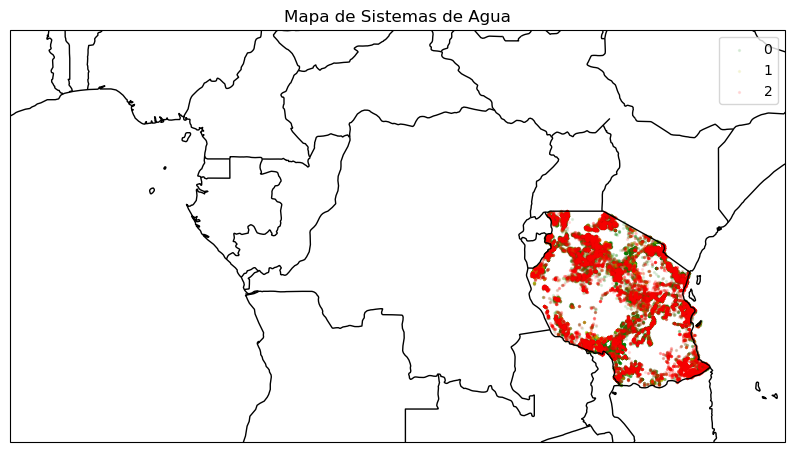

In [174]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Diccionario de colores para cada categoría de 'status_group'
color_map = {0: 'g', 1: 'y', 2: 'r'}  # Green, Yellow, Red para functional, functional needs repair, non functional respectivamente

# Crear una figura y ejes con un tamaño personalizado
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Establecer límites de los ejes para abarcar la región de África
ax.set_extent([-2, 45, -15, 10], crs=ccrs.PlateCarree())  # longitud mínima, longitud máxima, latitud mínima, latitud máxima

# Agregar contornos de costas
ax.coastlines()

# Agregar contornos de países
ax.add_feature(cfeature.BORDERS)

# Iterar sobre cada categoría y agregar marcadores con el color correspondiente y transparencia
for status, color in color_map.items():
    subset = data[data['status_group'] == status]
    ax.scatter(subset['longitude'], subset['latitude'], color=color, marker='o', label=status, transform=ccrs.PlateCarree(), alpha=0.1, s=2)

# Agregar título y leyenda
ax.set_title('Mapa de Sistemas de Agua')
ax.legend()

# Mostrar el mapa
plt.show()


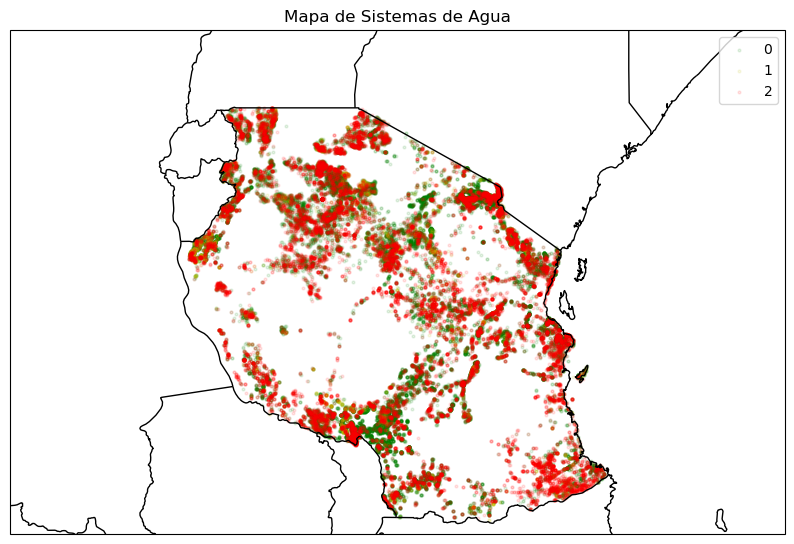

In [175]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Diccionario de colores para cada categoría de 'status_group'
color_map = {0: 'g', 1: 'y', 2: 'r'}  # Green, Yellow, Red para functional, functional needs repair, non functional respectivamente

# Crear una figura y ejes con un tamaño personalizado
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Establecer límites de los ejes para abarcar la región de África
ax.set_extent([25, 45, -12, 1], crs=ccrs.PlateCarree())  # longitud mínima, longitud máxima, latitud mínima, latitud máxima

# Agregar contornos de costas
ax.coastlines()

# Agregar contornos de países
ax.add_feature(cfeature.BORDERS)

# Iterar sobre cada categoría y agregar marcadores con el color correspondiente y transparencia
for status, color in color_map.items():
    subset = data[data['status_group'] == status]
    ax.scatter(subset['longitude'], subset['latitude'], color=color, marker='o', label=status, transform=ccrs.PlateCarree(), alpha=0.1, s=4)

# Agregar título y leyenda
ax.set_title('Mapa de Sistemas de Agua')
ax.legend()

# Mostrar el mapa
plt.show()

In [176]:
# Una idea discutida con algunos de los miembros de la clase era jugar con la distancia euclidiana, ya que tenemos trabajadas
# las variables de latiud y longitud.

# Calcular la distancia euclidiana entre cada par de coordenadas (latitud, longitud) y almacenarla en la variable "distancia"
data['distance'] = np.sqrt((data['latitude'])**2 + (data['longitude'])**2)

# Ahora, la variable 'distance' contiene las distancias euclidianas entre cada par de coordenadas (latitud, longitud).

In [177]:
data['distance'].value_counts()

distance
33.216008    1005
33.089846     807
33.062164       2
39.719595       2
39.709356       2
             ... 
32.999337       1
36.818506       1
36.772097       1
39.052993       1
38.696857       1
Name: count, Length: 57521, dtype: int64

In [178]:
data['distance'].describe()

count    59400.000000
mean        35.660783
std          2.736879
min         30.004511
25%         33.487462
50%         35.855938
75%         37.632209
max         41.688081
Name: distance, dtype: float64

In [179]:
# Lo mismo hare con data_test.

# Calcular la distancia euclidiana entre cada par de coordenadas (latitud, longitud) y almacenarla en la variable "distancia"
data_test['distance'] = np.sqrt((data_test['latitude'])**2 + (data_test['longitude'])**2)

# Ahora, la variable 'distance' contiene las distancias euclidianas entre cada par de coordenadas (latitud, longitud).

In [180]:
data_test['distance'].describe()

count    14850.000000
mean        35.650120
std          2.746207
min         30.007022
25%         33.439067
50%         35.864770
75%         37.669327
max         41.658351
Name: distance, dtype: float64

In [181]:
data_test['distance'].value_counts()

distance
33.211068    254
33.108277    203
37.931608      2
39.700779      2
37.985242      2
            ... 
36.797291      1
36.286886      1
36.817643      1
38.483649      1
36.532620      1
Name: count, Length: 14391, dtype: int64

#### Variable 'ward'

In [182]:
# No puedo tratar a 'ward' como 'funder' ya que las primeras 10 categorías más repetidas no son representativas del total de
# registros. En un principio la elimine, pero luego la trabaje con Label Encoder y el resultado en mi modelo mejoro.

data['ward'].value_counts()

ward
Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Kitete         1
Mitole         1
Themi          1
Thawi          1
Igogo          1
Name: count, Length: 2092, dtype: int64

In [183]:
# Posee una gran cantidad de valores únicos.

data['ward'].describe()

count     59400
unique     2092
top       Igosi
freq        307
Name: ward, dtype: object

In [184]:
# Crea un objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplica el LabelEncoder a la variable ward
data['ward'] = label_encoder.fit_transform(data['ward'])


In [185]:
# Aplica el LabelEncoder a la variable ward
data_test['ward'] = label_encoder.fit_transform(data_test['ward'])

#### Variable 'lga'

In [186]:
# Sucede algo muy similar a la variable 'ward', de todas formas mi modelo trabaja mejor sin esta variable.

data['lga'].value_counts()

lga
Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: count, Length: 125, dtype: int64

In [187]:
data['lga'].describe()

count      59400
unique       125
top       Njombe
freq        2503
Name: lga, dtype: object

In [188]:
# Elimino la variable 'lga'

data = data.drop(columns=['lga'])

In [189]:
data_test = data_test.drop(columns=['lga'])

#### Variable 'amount_tsh'

In [190]:
data['amount_tsh'].describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [191]:
data['amount_tsh'].value_counts().head(20)

amount_tsh
0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
200.0      1220
100.0       816
10.0        806
30.0        743
2000.0      704
250.0       569
300.0       557
5000.0      450
5.0         376
25.0        356
3000.0      334
1200.0      267
1500.0      197
6.0         190
600.0       176
Name: count, dtype: int64

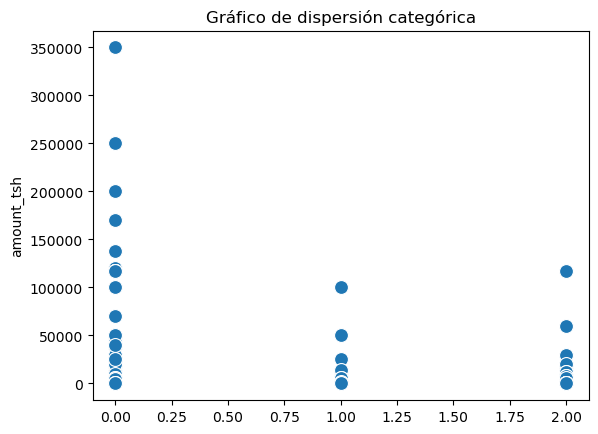

In [192]:
# Este variable en teoría representa la cantidad de agua disponible para cada sistema de agua. Sin embargo en datadriven no
# aclara la unidad de medida. Además, un porcentaje muy grande de registros es = 0.0, 
# esto puede ser debido a que no hay información o a que no tienen agua, que parece ser un monto muy abultado para esta lógica.

# Desconociendo del tema, me sigue pareciendo extrano la gran cantidad de sistemas sin agua disponible, por más que sepamos 
# que en África puede ser un bien escaso.

# Primero que nada quiero ver la relacion de amount_tsh vs status_group y amount_tsh vs basin (que representa la cuenca
# de donde se saca el agua). 

sns.scatterplot(data=data, x='status_group', y='amount_tsh', s=100)
plt.xlabel('')
plt.ylabel('amount_tsh')
plt.title('Gráfico de dispersión categórica')
plt.show()

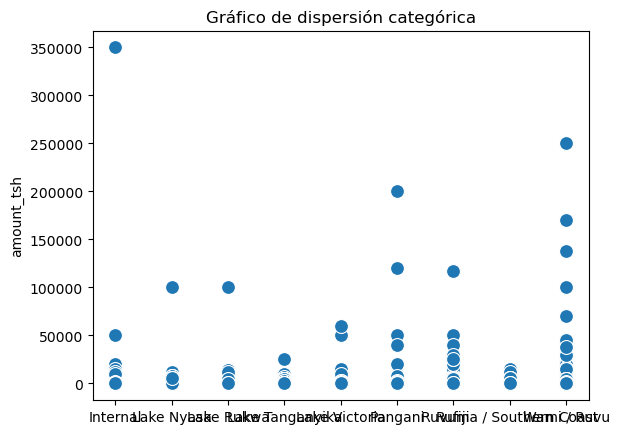

In [193]:
sns.scatterplot(data=data, x='basin', y='amount_tsh', s=100)
plt.xlabel('')
plt.ylabel('amount_tsh')
plt.title('Gráfico de dispersión categórica')
plt.show()

In [194]:
# Por lo que veo comparando amount_tsh vs status_group, puede ser que el sistema funcione por más que no tenga agua. Sin embargo,
# al hacer amount_tsh vs basin, veo que sistemas que salen de la misma cuenca tienen diferentes cantidades de agua, por lo que
# concluyo que el 0 en amount_tsh puede ser valores perdidos. Al ser tan grande la cantidad de valores = 0, decido descartar 
# esta variable, ya que no podria imputar esa cantidad de valores.

data = data.drop(columns='amount_tsh')

In [195]:
data_test = data_test.drop(columns='amount_tsh')

#### Variable 'gps_height'

In [196]:
data['gps_height'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [197]:
data['gps_height'].value_counts()

gps_height
 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: count, Length: 2428, dtype: int64

In [198]:
# 'gps_height' es otra variable que ayuda con la localización. En este caso cuenta con 20438 valores = 0, por lo que probablemente
# sean valores nulos. Descarto esta variable.

data = data.drop(columns='gps_height')

In [199]:
data_test = data_test.drop(columns='gps_height')

#### Variable 'num_private'

Esta variable no tiene descripción en datadriven, por lo que cuesta interpretarla.

In [200]:
data['num_private'].describe()

count    59400.000000
mean         0.474141
std         12.236230
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1776.000000
Name: num_private, dtype: float64

In [201]:
data['num_private'].value_counts()

num_private
0       58643
6          81
1          73
5          46
8          46
        ...  
42          1
23          1
136         1
698         1
1402        1
Name: count, Length: 65, dtype: int64

In [202]:
# Decido eliminarla debido a la difucultad de interpretación y a la gran cantidad de registros = 0.

data = data.drop(columns='num_private')

In [203]:
data_test = data_test.drop(columns='num_private')

#### Variable 'district_code'

En un principio elimine esta variable, pero luego intente pasarla a categórica y reducir sus categorías, mejoro mi modelo.

In [204]:
data['district_code'].describe()

count    59400.000000
mean         5.629747
std          9.633649
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         80.000000
Name: district_code, dtype: float64

In [205]:
data['district_code'].nunique()

20

In [206]:
data['district_code'].value_counts()

district_code
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: count, dtype: int64

In [207]:
data['district_code'] = data['district_code'].astype('object')

In [208]:
data_test['district_code'] = data_test['district_code'].astype('object')

In [209]:
data['district_code'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: district_code
Non-Null Count  Dtype 
--------------  ----- 
59400 non-null  object
dtypes: object(1)
memory usage: 464.2+ KB


In [210]:
data['district_code'].describe()

count     59400
unique       20
top           1
freq      12203
Name: district_code, dtype: int64

In [211]:
data['district_code'].value_counts()

district_code
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: count, dtype: int64

In [212]:
reducir_categorias(data, 'district_code', 8)

district_code
1        12203
2        11173
3         9998
4         8999
Other     5254
5         4356
6         4074
7         3343
Name: count, dtype: int64

In [213]:
data_test['district_code'].value_counts()

district_code
1     3096
2     2756
3     2523
4     2254
5     1072
6     1034
7      823
30     261
8      239
33     189
53     176
43     148
13     105
63      69
23      67
62      18
60      13
0        4
67       2
80       1
Name: count, dtype: int64

In [214]:
data_test['district_code'].describe()

count     14850
unique       20
top           1
freq       3096
Name: district_code, dtype: int64

In [215]:
reducir_categorias(data_test, 'district_code', 8)

district_code
1        3096
2        2756
3        2523
4        2254
Other    1292
5        1072
6        1034
7         823
Name: count, dtype: int64

In [216]:
data['district_code'] = data['district_code'].astype('category')


In [217]:
data_test['district_code'] = data_test['district_code'].astype('category')

In [218]:
data

,id,date_recorded,funder,installer,longitude,latitude,basin,region,district_code,ward,...,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,waterpoint_type_group,status_group,distance
0,69572,995,Other,Other,34.938093,-9.856322,Lake Nyasa,Iringa,5,1426,...,gravity,vwc,user-group,annually,good,enough,spring,communal standpipe,0,36.301755
1,8776,272,Other,Other,34.698766,-2.147466,Lake Victoria,Other,2,1576,...,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,0,34.765155
2,34310,281,Other,Other,37.460664,-3.821329,Pangani,Other,4,1624,...,gravity,vwc,user-group,per bucket,good,enough,dam,communal standpipe,0,37.655065
3,67743,309,Unicef,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Other,Other,1571,...,submersible,vwc,user-group,never pay,good,dry,borehole,communal standpipe,2,40.070254
4,19728,874,Other,Other,31.130847,-1.825359,Lake Victoria,Kagera,1,1687,...,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,0,31.184316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,214,Other,Other,37.169807,-3.253847,Pangani,Kilimanjaro,5,1090,...,gravity,water board,user-group,per bucket,good,enough,spring,communal standpipe,0,37.311956
59396,27263,941,Other,Other,35.249991,-9.070629,Rufiji,Iringa,4,353,...,gravity,vwc,user-group,annually,good,enough,river/lake,communal standpipe,0,36.398327
59397,37057,967,Other,Other,34.017087,-8.750434,Rufiji,Mbeya,7,177,...,handpump,vwc,user-group,monthly,fluoride,enough,borehole,hand pump,0,35.124526
59398,31282,1001,Other,Other,35.861315,-6.378573,Rufiji,Other,4,1449,...,handpump,vwc,user-group,never pay,good,insufficient,shallow well,hand pump,0,36.424170


#### Variable 'population'

Conserve esta variable sin modificaciones.

In [219]:
data['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [220]:
data['population'].value_counts()

population
0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: count, Length: 1049, dtype: int64

#### Variable 'constuction_year'

In [221]:
data['construction_year'].describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [222]:
data['construction_year'].value_counts()

construction_year
0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: count, dtype: int64

In [223]:
# Para reducir un poco los valores unicos, analizo la opción de pasar los años a decadas.

def convertir_a_decada(año):
    if año >= 1960 and año < 1970:
        return 60
    elif año >= 1970 and año < 1980:
        return 70
    elif año >= 1980 and año < 1990:
        return 80
    elif año >= 1990 and año < 2000:
        return 90
    elif año >= 2000 and año < 2010:
        return 2000
    elif año >= 2010:
        return 2010
    else:
        return 'unknown'

In [224]:
data['construction_decade'] = data['construction_year'].apply(convertir_a_decada)

In [225]:
data['construction_decade'].value_counts()

construction_decade
unknown    20709
2000       15330
90          7678
80          5578
2010        5161
70          4406
60           538
Name: count, dtype: int64

In [226]:
data = data.drop(columns='construction_year')

In [227]:
data['construction_decade'] = data['construction_decade'].astype('category')

In [228]:
# Reptio el proceso para data_test:

data_test['construction_decade'] = data_test['construction_year'].apply(convertir_a_decada)

In [229]:
data_test['construction_decade'].value_counts()

construction_decade
unknown    5260
2000       3833
90         1933
80         1361
2010       1300
70         1042
60          121
Name: count, dtype: int64

In [230]:
data_test = data_test.drop(columns='construction_year')

In [231]:
data_test['construction_decade'] = data_test['construction_decade'].astype('category')

#### Variable 'id'

In [232]:
# La convierto en índice.

data.set_index('id', inplace=True)

In [233]:
data.head()

,date_recorded,funder,installer,longitude,latitude,basin,region,district_code,ward,population,...,management,management_group,payment_type,quality_group,quantity_group,source_type,waterpoint_type_group,status_group,distance,construction_decade
id,,,,,,,,,,,,,,,,,,,,,
69572,995,Other,Other,34.938093,-9.856322,Lake Nyasa,Iringa,5,1426,109,...,vwc,user-group,annually,good,enough,spring,communal standpipe,0,36.301755,90
8776,272,Other,Other,34.698766,-2.147466,Lake Victoria,Other,2,1576,280,...,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,0,34.765155,2010
34310,281,Other,Other,37.460664,-3.821329,Pangani,Other,4,1624,250,...,vwc,user-group,per bucket,good,enough,dam,communal standpipe,0,37.655065,2000
67743,309,Unicef,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Other,Other,1571,58,...,vwc,user-group,never pay,good,dry,borehole,communal standpipe,2,40.070254,80
19728,874,Other,Other,31.130847,-1.825359,Lake Victoria,Kagera,1,1687,0,...,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,0,31.184316,unknown


In [234]:
data_test.set_index('id', inplace=True)

In [235]:
data_test.head(1)

,date_recorded,funder,installer,longitude,latitude,basin,region,district_code,ward,population,...,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,waterpoint_type_group,distance,construction_decade
id,,,,,,,,,,,,,,,,,,,,,
50785,302,Other,Other,35.290799,-4.059696,Internal,Other,3,17,321,...,other,parastatal,parastatal,never pay,good,seasonal,rainwater harvesting,other,35.523536,2010


In [236]:
data.apply(lambda x: len(x.unique()))

date_recorded              356
funder                      10
installer                    8
longitude                57517
latitude                 57517
basin                        9
region                       9
district_code                8
ward                      2092
population                1049
public_meeting               2
scheme_management           10
permit                       2
extraction_type_class        7
management                   9
management_group             4
payment_type                 6
quality_group                6
quantity_group               5
source_type                  7
waterpoint_type_group        6
status_group                 3
distance                 57521
construction_decade          7
dtype: int64

In [237]:
data_test.apply(lambda x: len(x.unique()))

date_recorded              331
funder                      10
installer                    8
longitude                14389
latitude                 14389
basin                        9
region                       9
district_code                8
ward                      1959
population                 637
public_meeting               2
scheme_management           10
permit                       2
extraction_type_class        7
management                   9
management_group             4
payment_type                 6
quality_group                6
quantity_group               5
source_type                  7
waterpoint_type_group        6
distance                 14391
construction_decade          7
dtype: int64

In [238]:
data.shape

(59400, 24)

In [239]:
data_test.shape

(14850, 23)

### Gráficos Variables Categóricas

In [240]:
def plot_categorical_frequency(data):
    """
    Función para graficar la frecuencia de las categorías en todas las columnas categóricas del DataFrame.
    
    Parámetros:
    data : DataFrame
        El DataFrame que contiene los datos.
    """
    # Seleccionar solo las columnas categóricas
    cat_cols = data.select_dtypes(include='category')
    
    # Iterar sobre las columnas categóricas y graficar la frecuencia de las categorías
    for col in cat_cols.columns:
        # Contar la frecuencia de cada categoría
        category_counts = data[col].value_counts()
    
        # Crear un gráfico de barras
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    
        # Ajustar etiquetas y título
        plt.xticks(rotation=45)
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de {col}')
    
        # Mostrar el gráfico
        plt.show()


C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


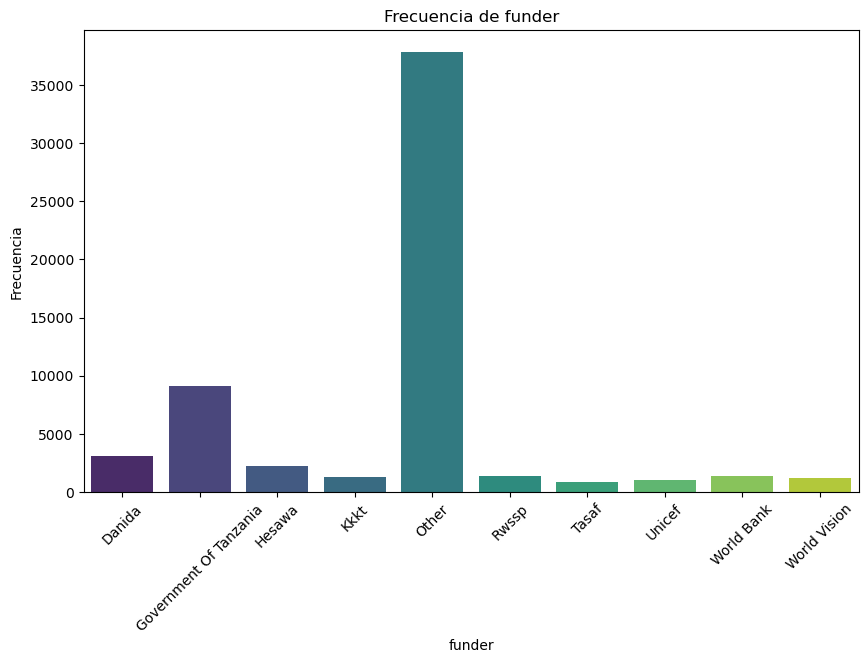

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


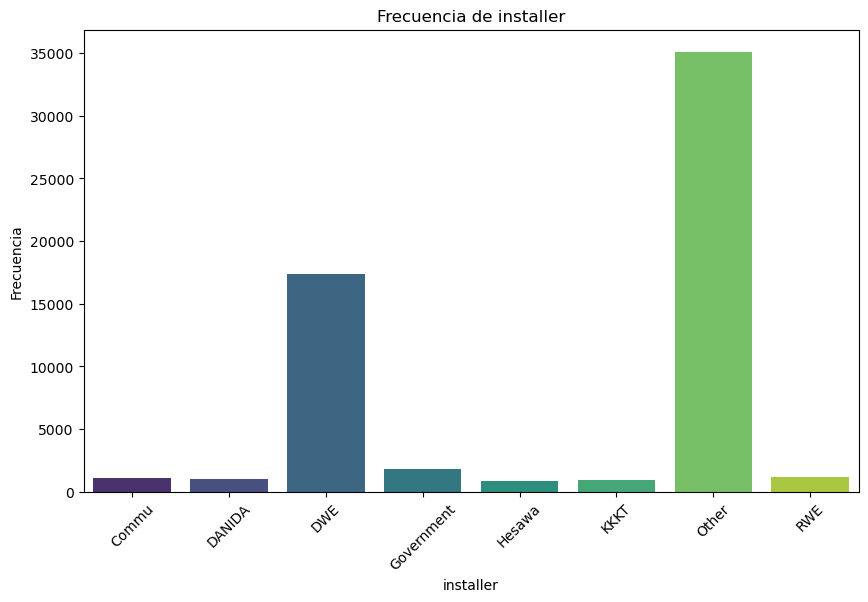

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


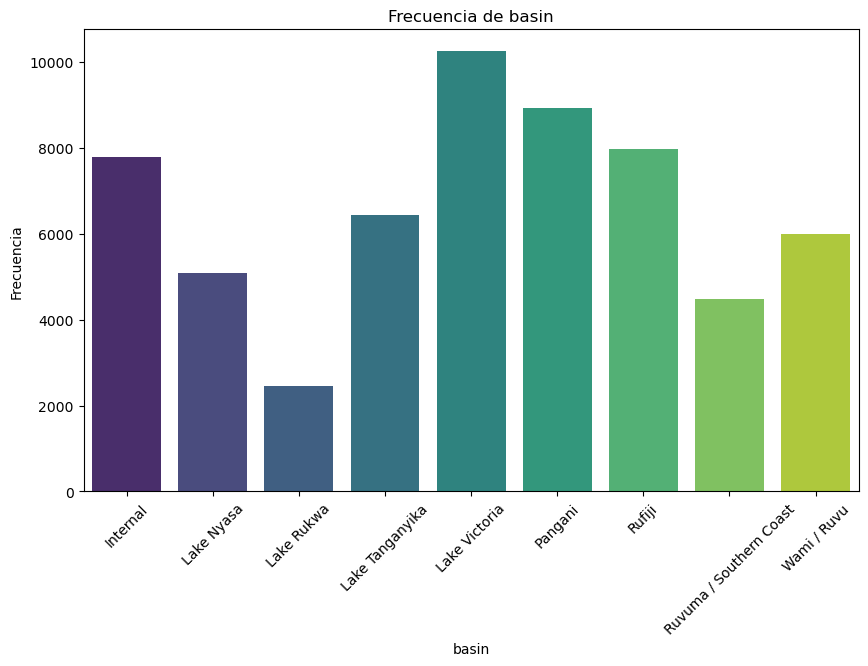

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


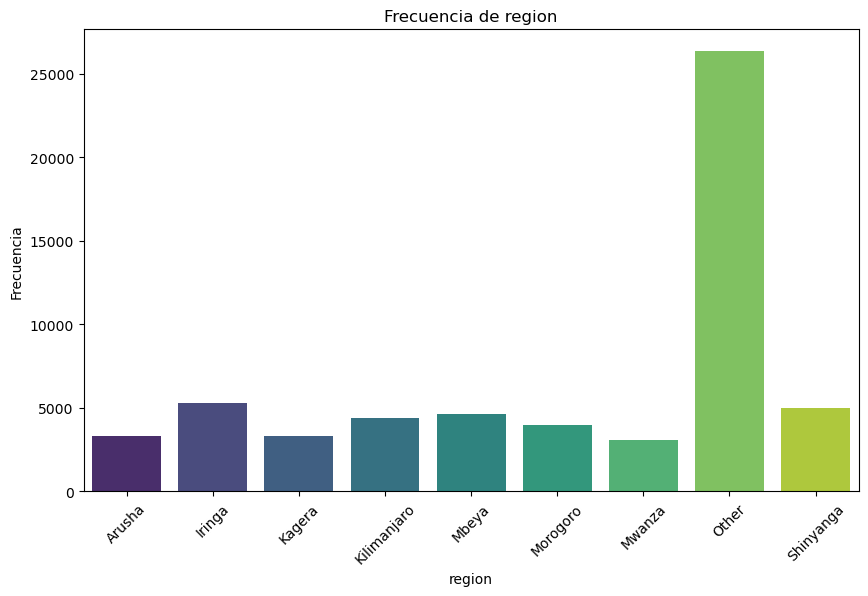

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


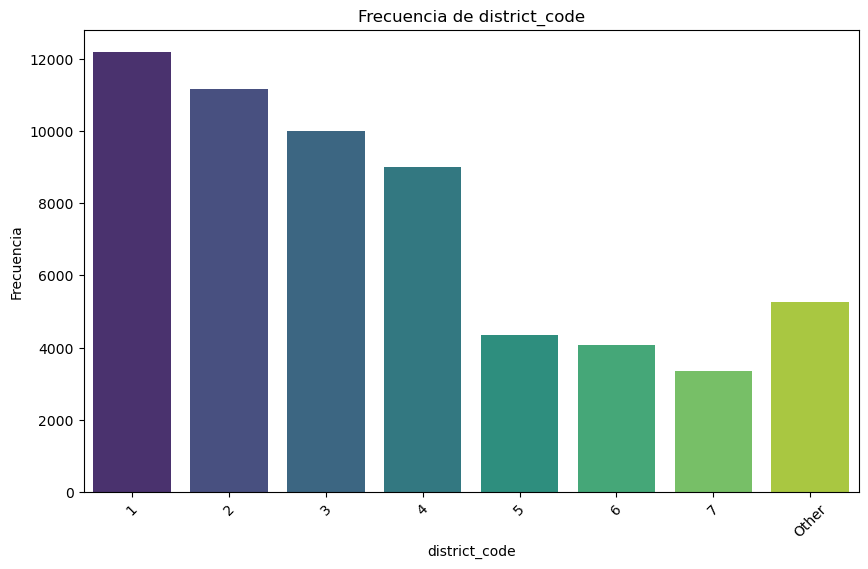

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


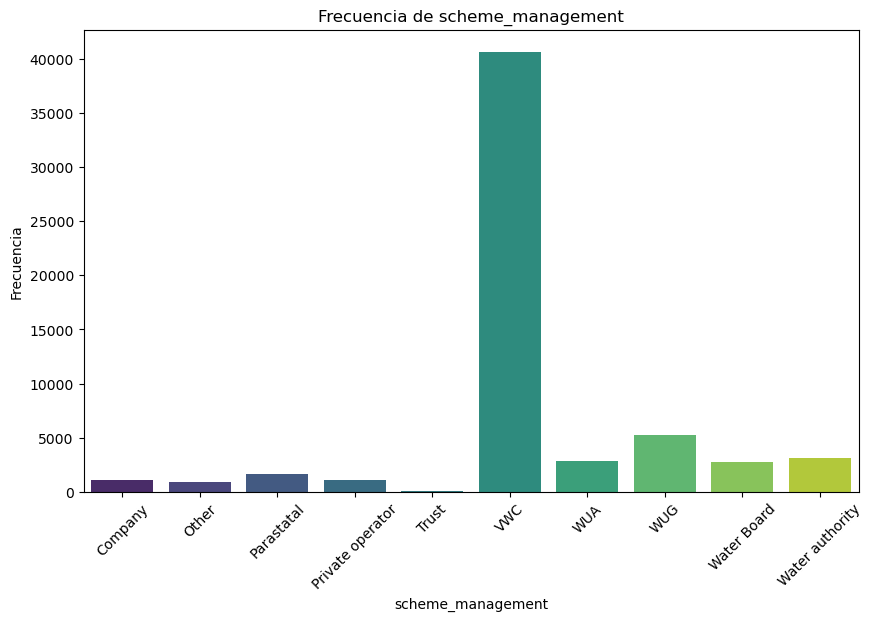

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


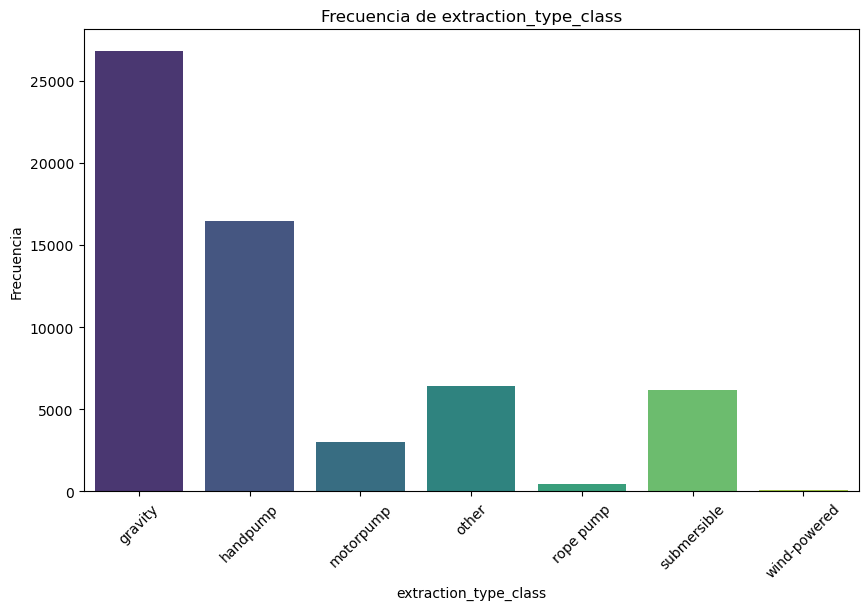

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


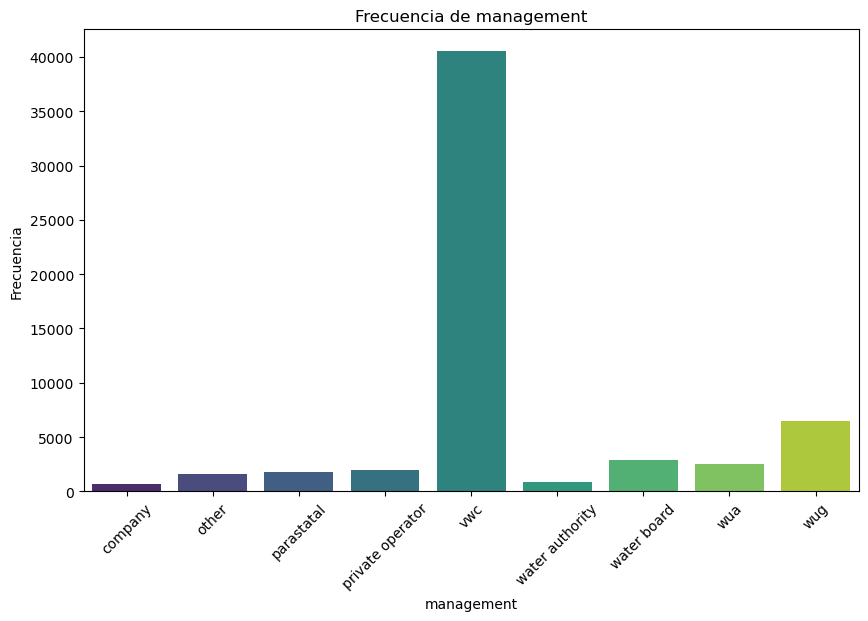

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


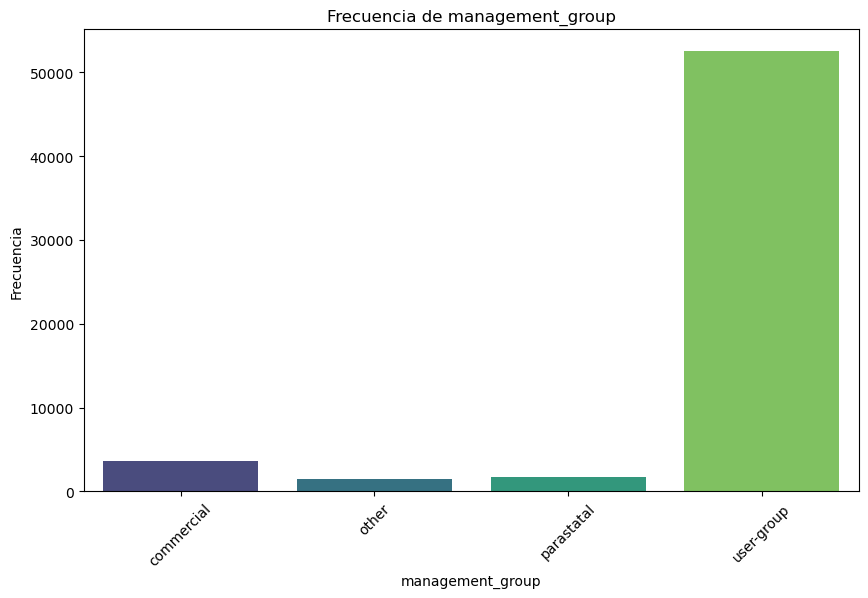

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


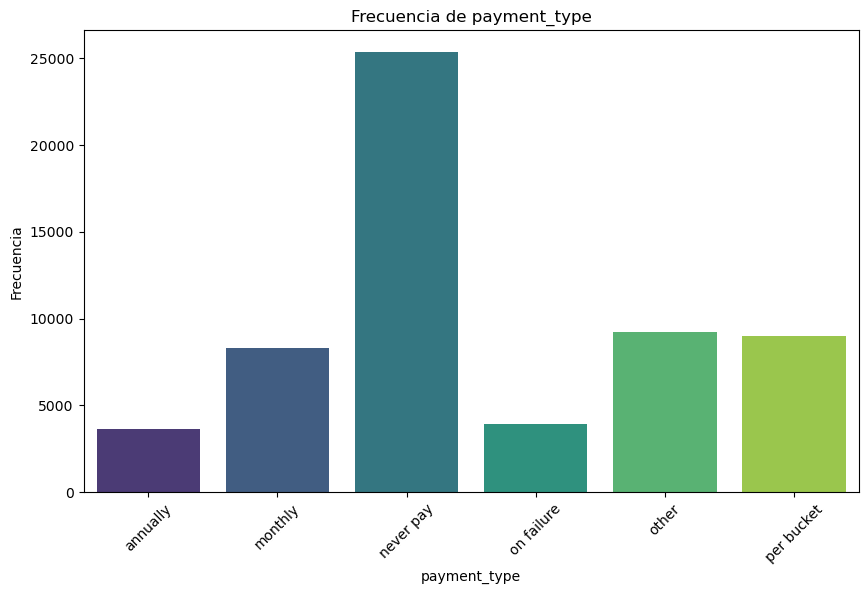

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


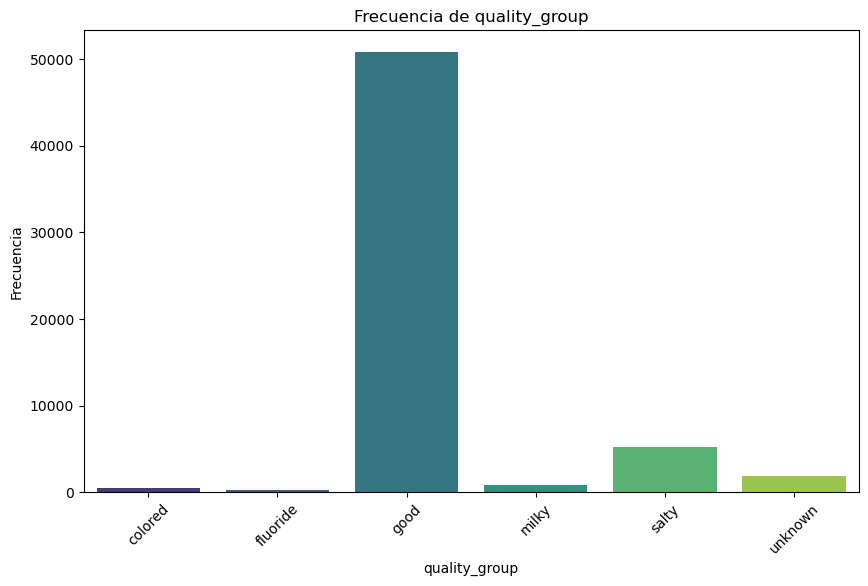

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


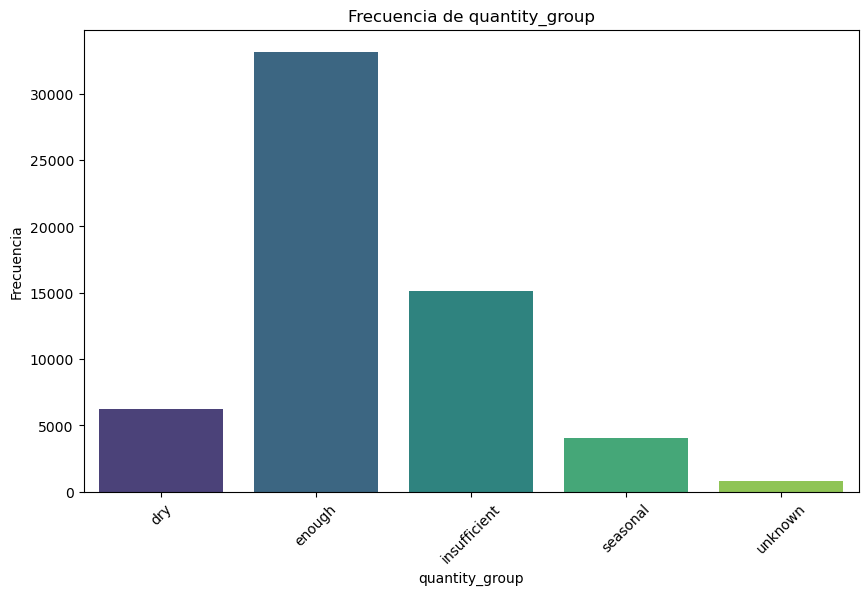

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


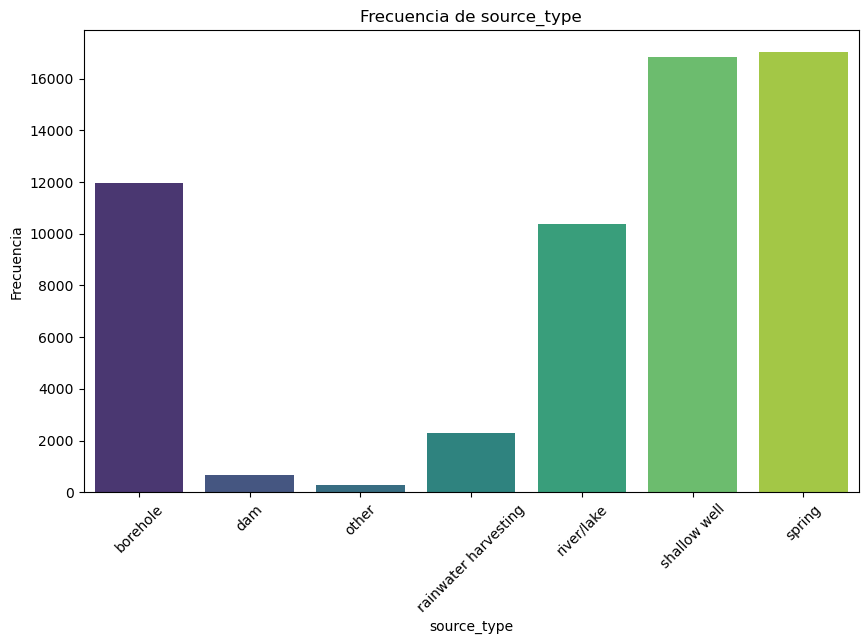

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


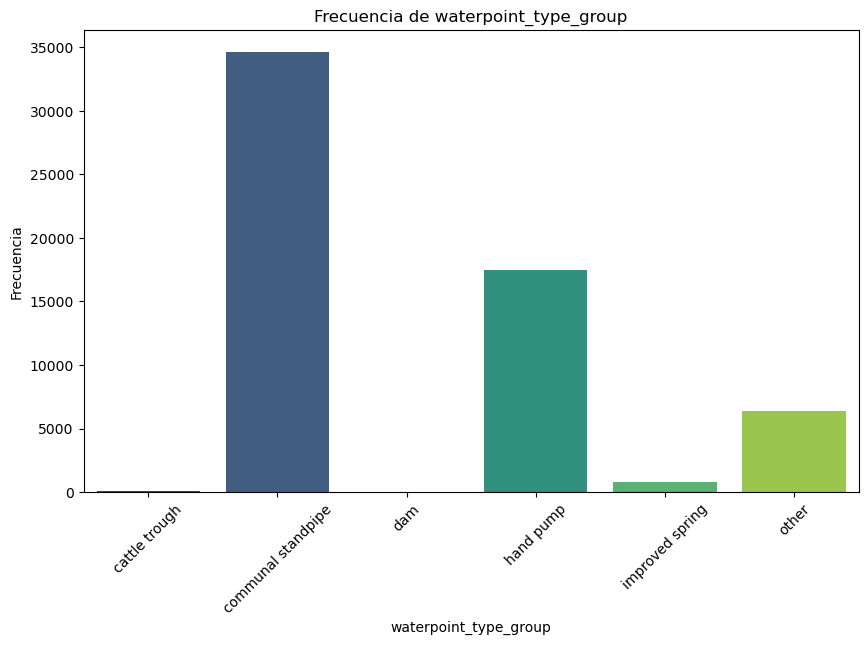

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


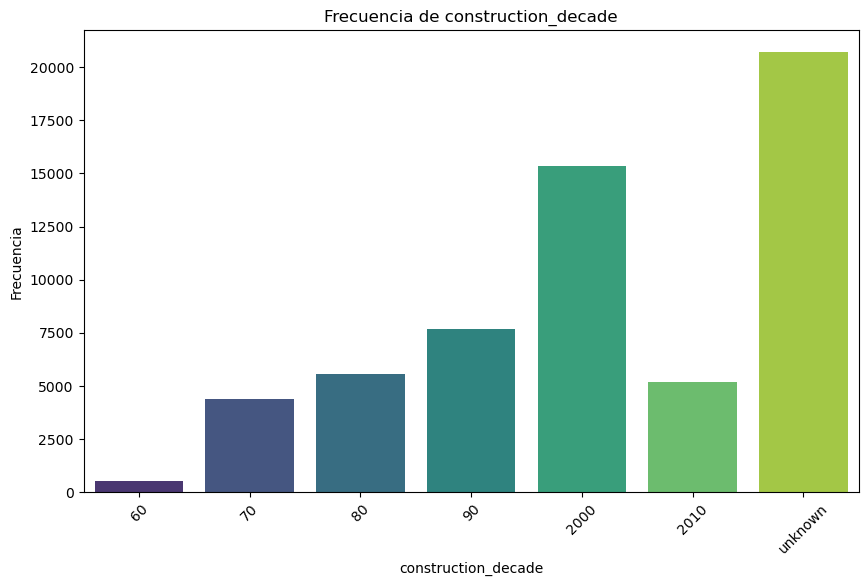

In [241]:
plot_categorical_frequency(data)

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


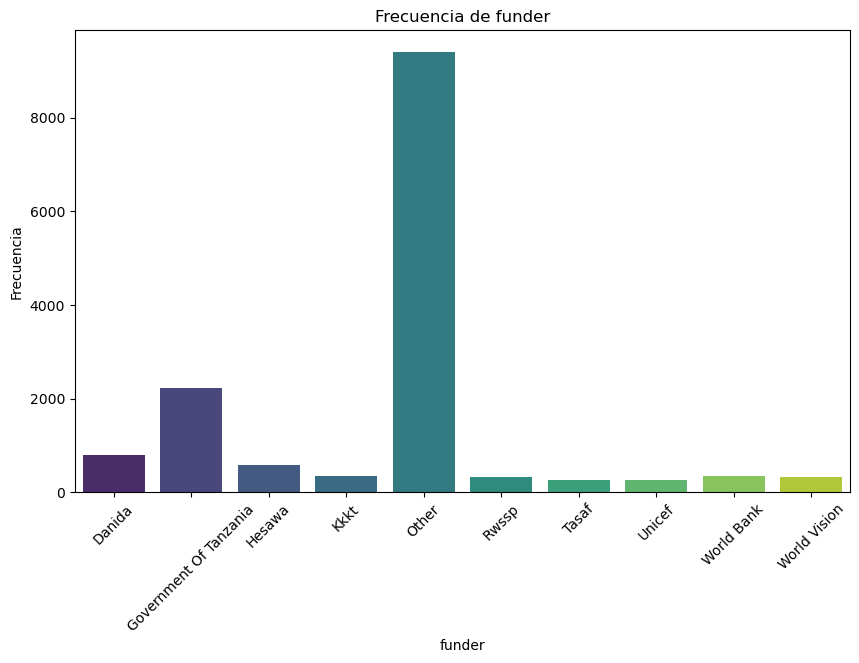

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


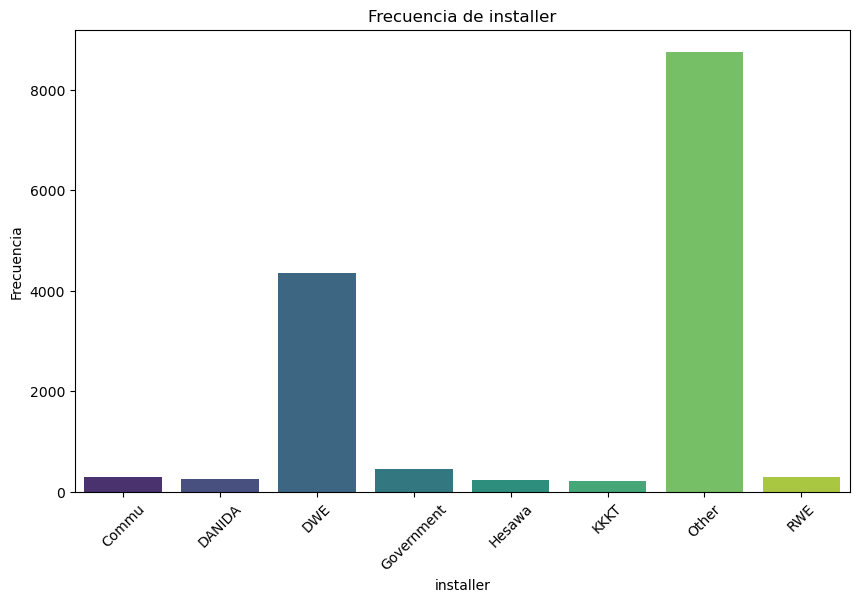

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


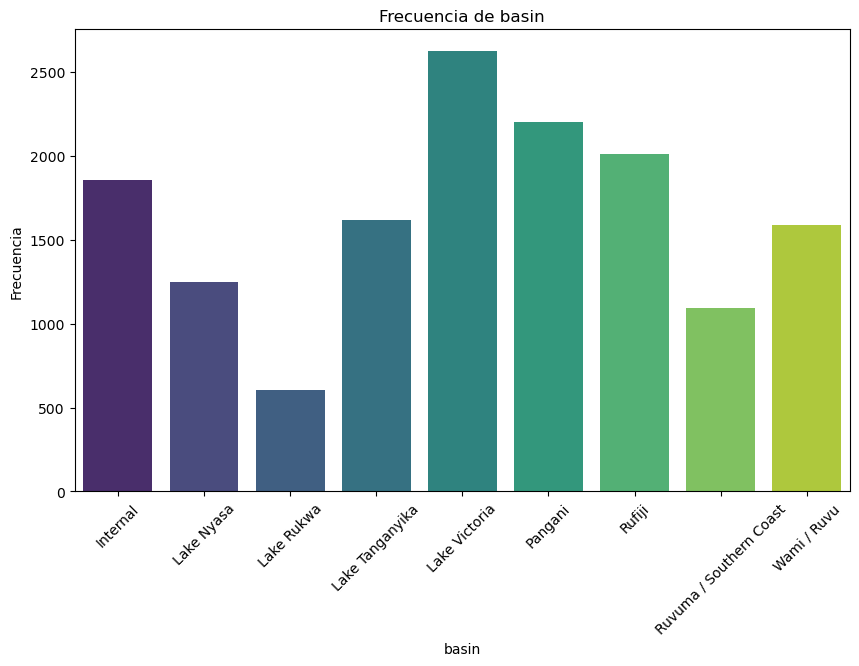

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


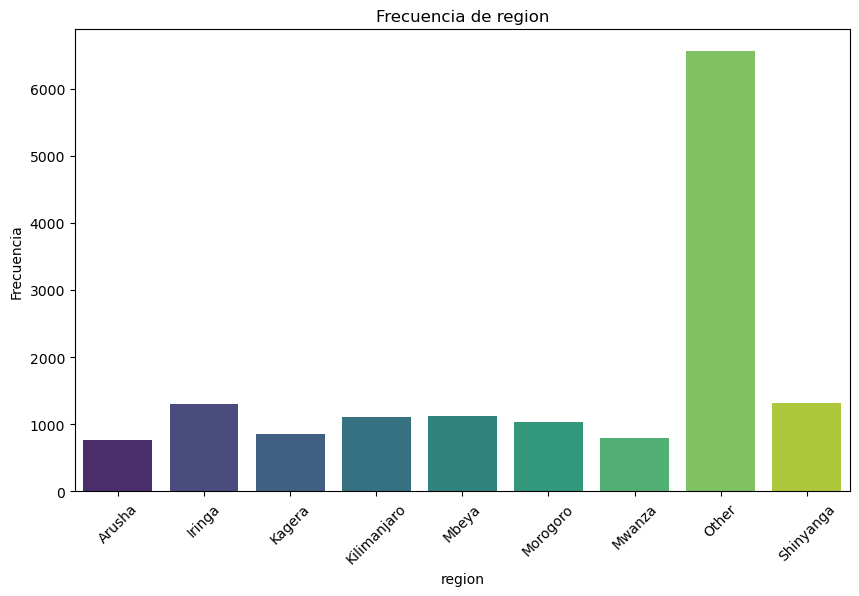

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


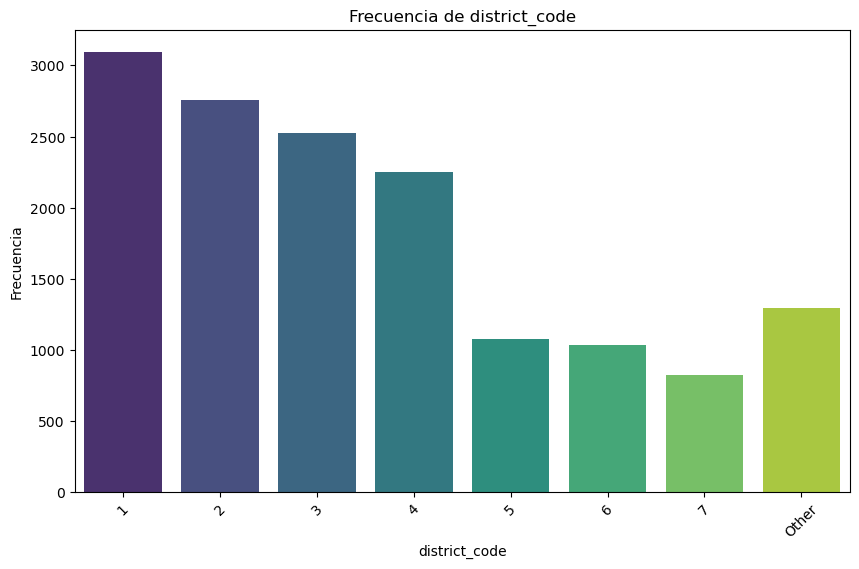

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


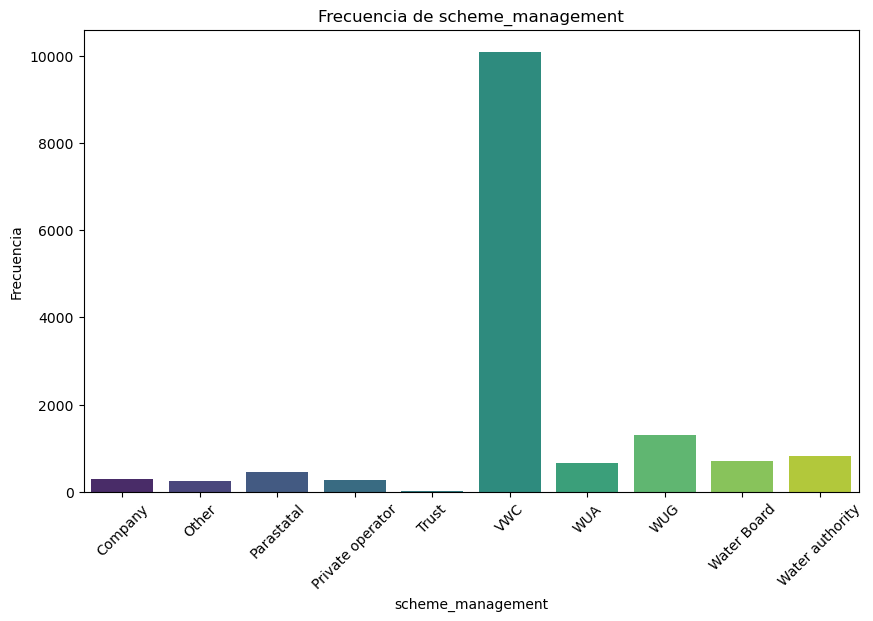

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


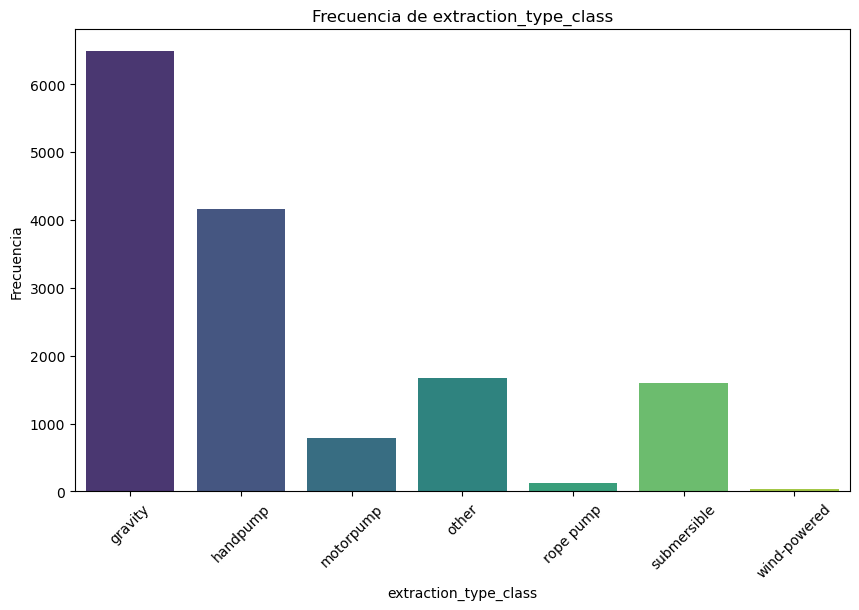

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


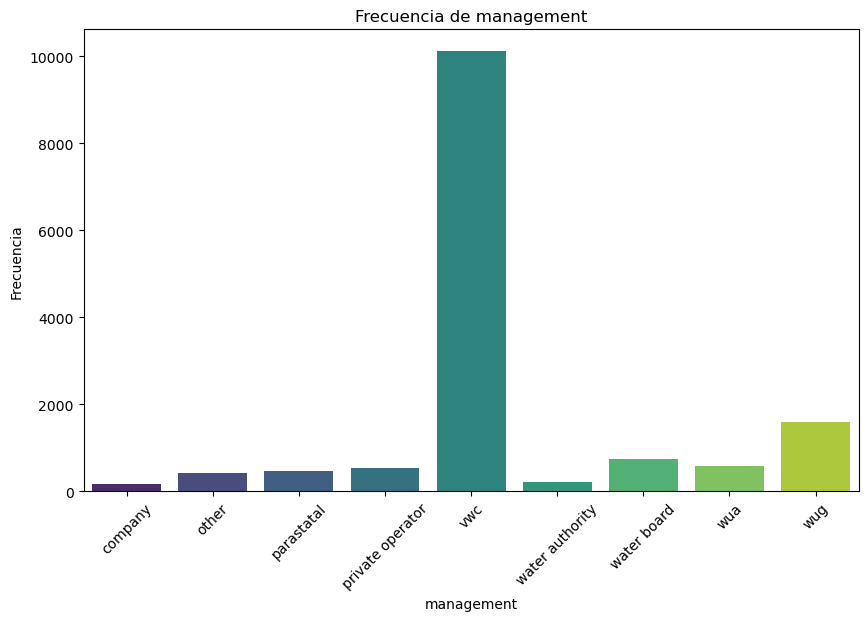

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


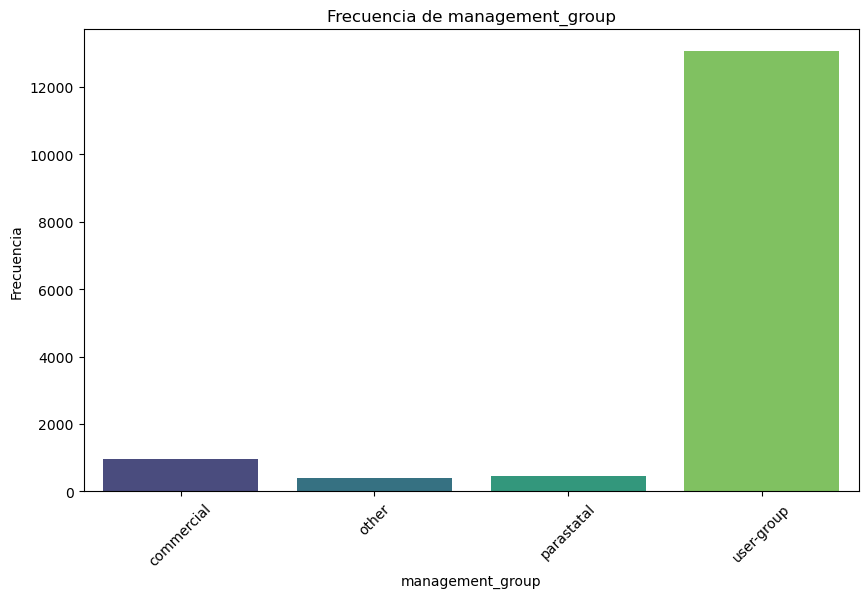

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


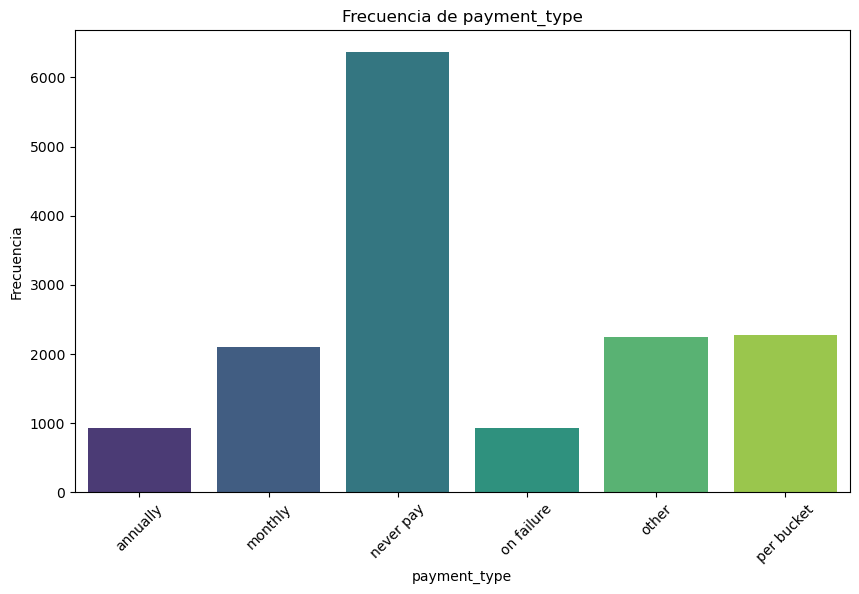

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


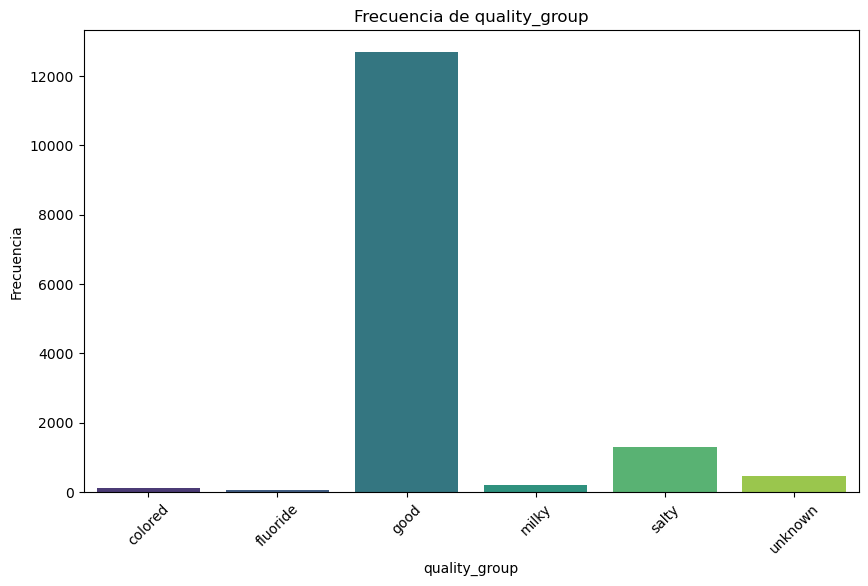

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


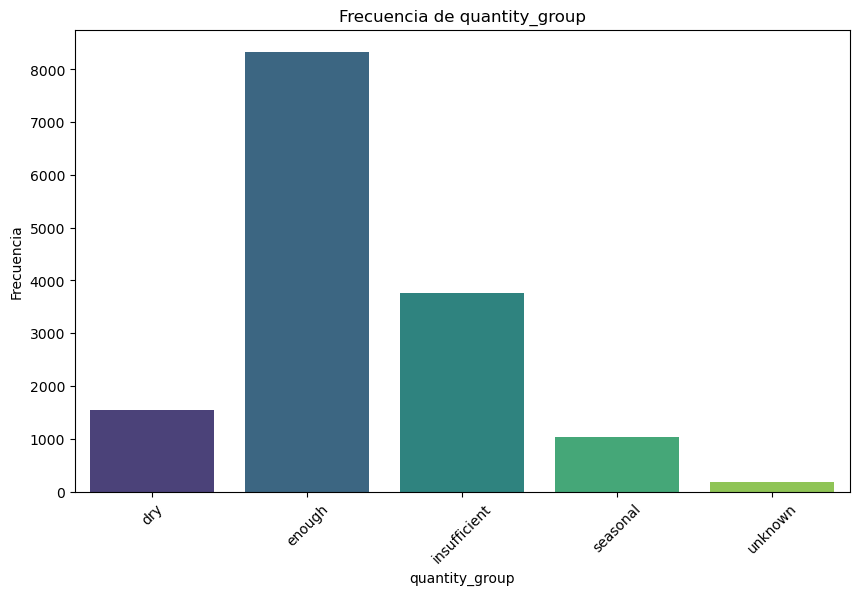

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


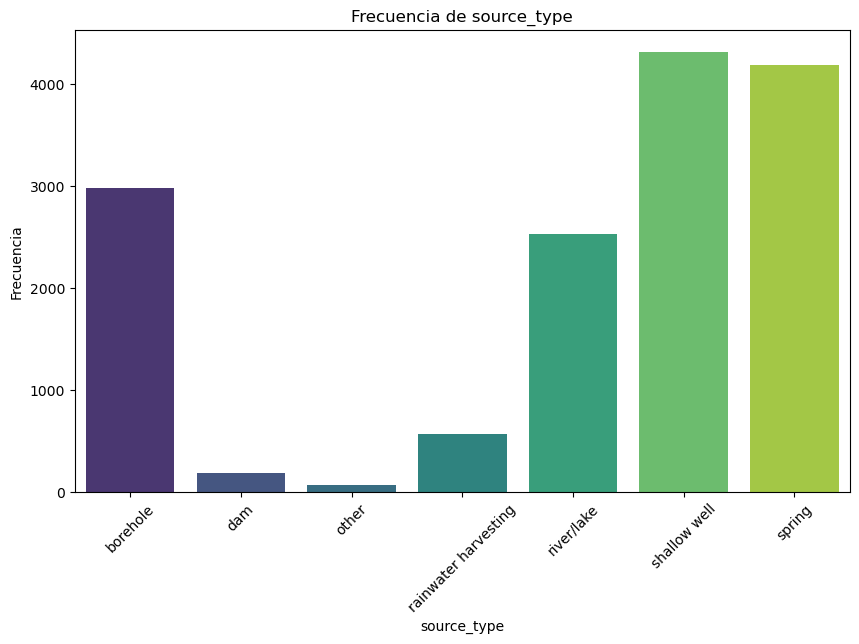

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


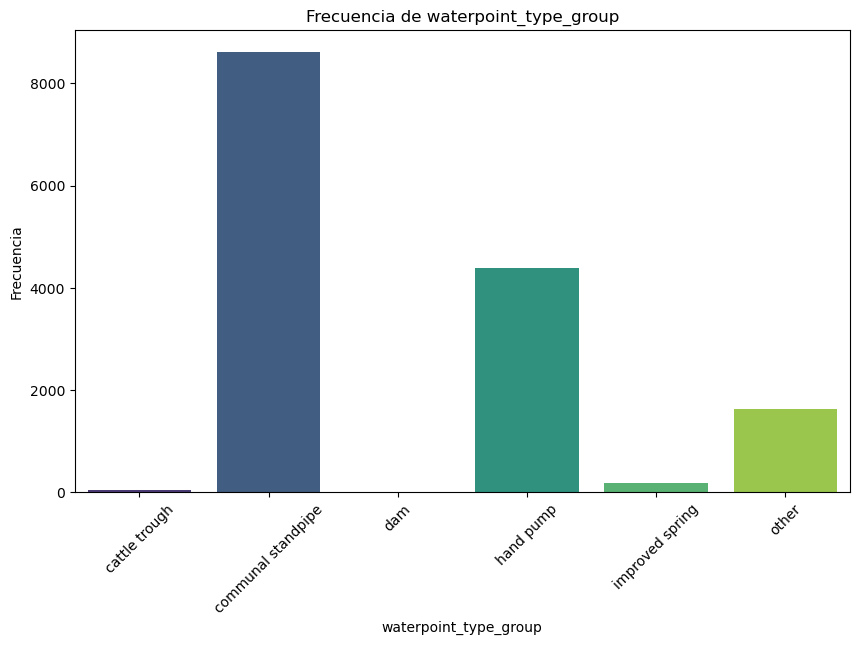

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


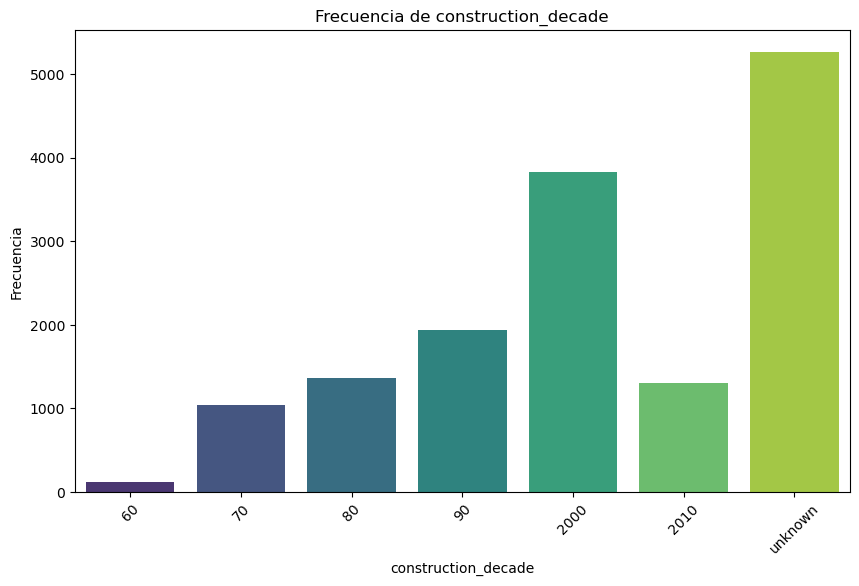

In [242]:
plot_categorical_frequency(data_test)

In [243]:
data.to_csv('data_pre_codification.csv')

In [244]:
data_test.to_csv('data_test_pre_codification.csv')

### Variables categóricas a dummies

In [245]:
dummy_cols = data.select_dtypes(include=['category']).columns

In [246]:
data = pd.get_dummies(data, columns = dummy_cols)

In [247]:
data.shape

(59400, 120)

In [248]:
dummy_cols_test = data_test.select_dtypes(include=['category']).columns

In [249]:
data_test = pd.get_dummies(data_test, columns = dummy_cols_test)

In [250]:
data_test.shape

(14850, 119)

### Correlaciones mas fuertes con la variable 'status_group'

In [251]:
matriz_correlacion = data.corr()

correlacion_objetivo = matriz_correlacion['status_group']

correlaciones_fuertes = correlacion_objetivo[(correlacion_objetivo > 0.1) | (correlacion_objetivo < -0.1)]

correlaciones_fuertes

status_group                      1.000000
funder_Government Of Tanzania     0.117499
funder_Other                     -0.103378
basin_Ruvuma / Southern Coast     0.103276
region_Iringa                    -0.141223
region_Other                      0.117300
scheme_management_VWC             0.110863
extraction_type_class_gravity    -0.134059
extraction_type_class_handpump   -0.105952
extraction_type_class_other       0.295936
management_vwc                    0.125598
payment_type_annually            -0.111307
payment_type_monthly             -0.116186
payment_type_never pay            0.168765
payment_type_per bucket          -0.107686
quality_group_good               -0.127763
quality_group_unknown             0.163276
quantity_group_dry                0.397962
quantity_group_enough            -0.258402
source_type_spring               -0.107233
waterpoint_type_group_other       0.310295
construction_decade_70            0.131614
construction_decade_2000         -0.129218
constructio

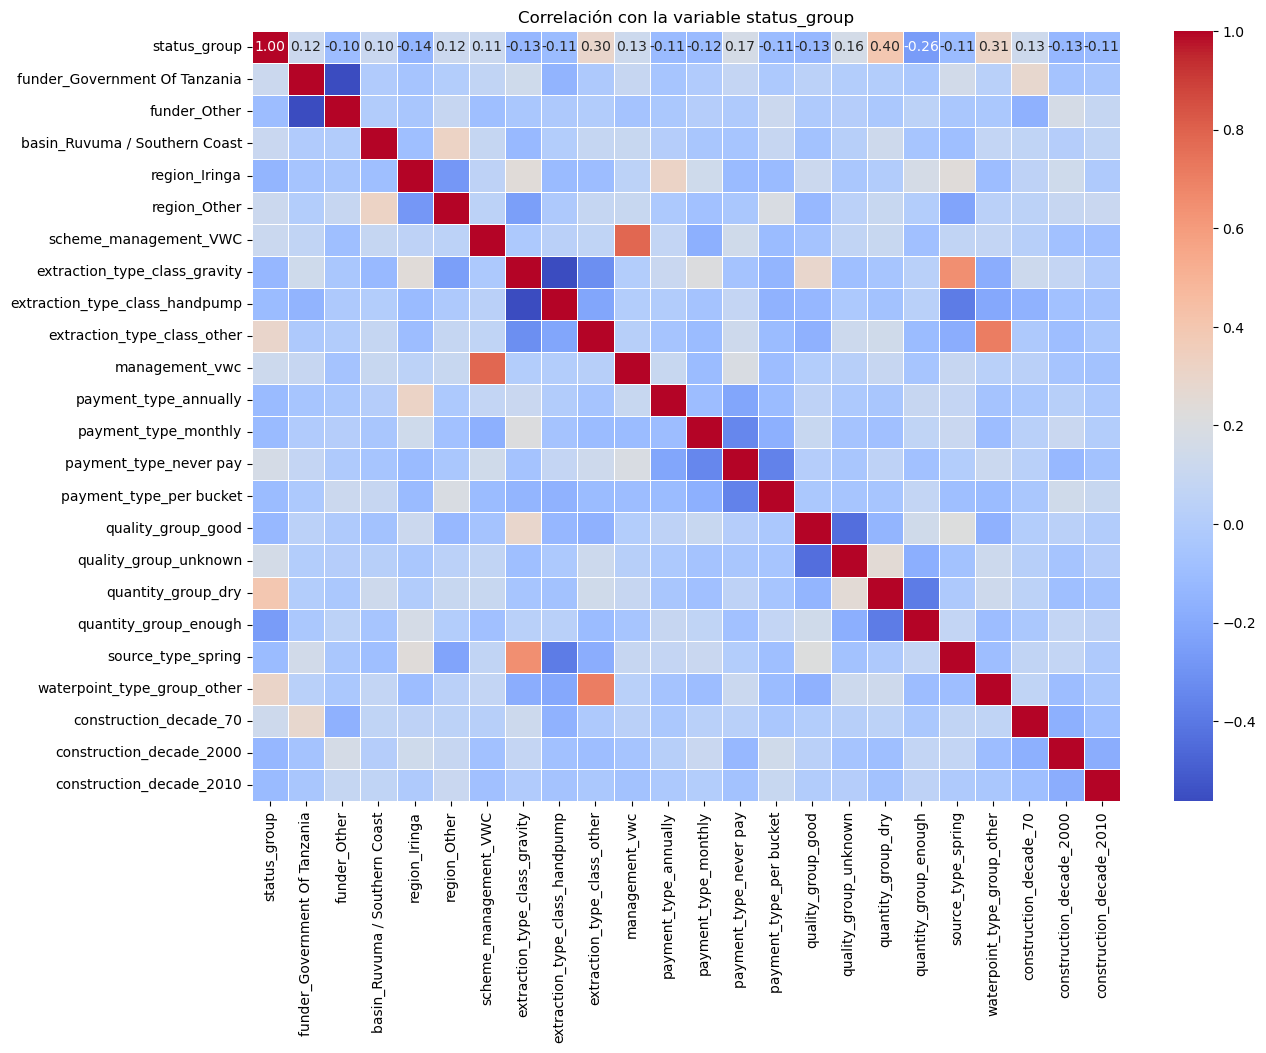

In [252]:
correlaciones_significativas = matriz_correlacion.loc[correlaciones_fuertes.index, correlaciones_fuertes.index]

# Mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(correlaciones_significativas, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación con la variable status_group')
plt.show()

### Oversampling

Utilizo SMOTE para hacer oversampling en la variable a predecir, 'functional needs repair' es la clase menos frecuente. 

C:\Users\Guillermo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Guillermo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\Guillermo\AppData\Local\Temp\ipykernel_16912\3584287070.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['status_group'] = y_resampled


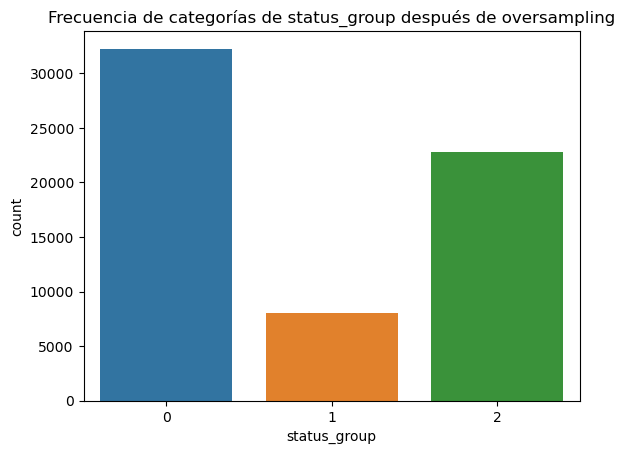

In [253]:
from imblearn.over_sampling import SMOTE

# Separar características y variable objetivo
X = data.drop(columns=['status_group'])
y = data['status_group']

# Aplicar SMOTE para hacer oversampling de la categoría menos frecuente
smote = SMOTE(sampling_strategy={1: 8000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convertir el resultado a un DataFrame de Pandas para visualización
data = pd.DataFrame(X_resampled, columns=X.columns)
data['status_group'] = y_resampled

# Mostrar la nueva frecuencia de las categorías de status_group
sns.countplot(x='status_group', data=data)
plt.title('Frecuencia de categorías de status_group después de oversampling')
plt.show()


In [254]:
data.shape

(63083, 120)

### Gráficos Variables Numéricas

In [255]:
def plot_numeric_distribution(data):
    """
    Función para graficar la distribución de variables numéricas en el DataFrame.
    
    Parámetros:
    data : DataFrame
        El DataFrame que contiene los datos.
    """
    # Seleccionar solo las columnas numéricas
    num_cols = data.select_dtypes(include='number')
    
    # Iterar sobre las columnas numéricas y graficar la distribución
    for col in num_cols.columns:
        # Crear un histograma con boxplot utilizando Seaborn
        plt.figure(figsize=(10, 6))
        sns.histplot(data[col], kde=True, color='skyblue', bins=30)
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.title(f'Distribución de {col}')
        plt.show()

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


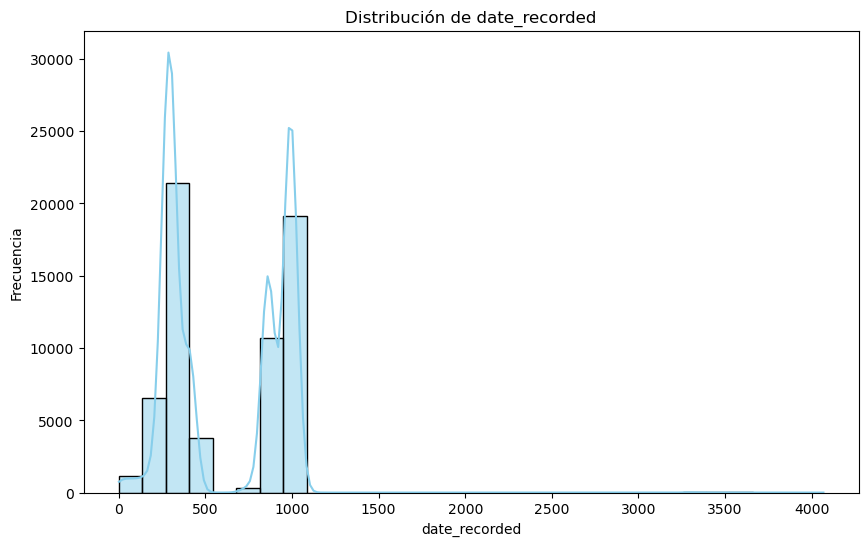

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


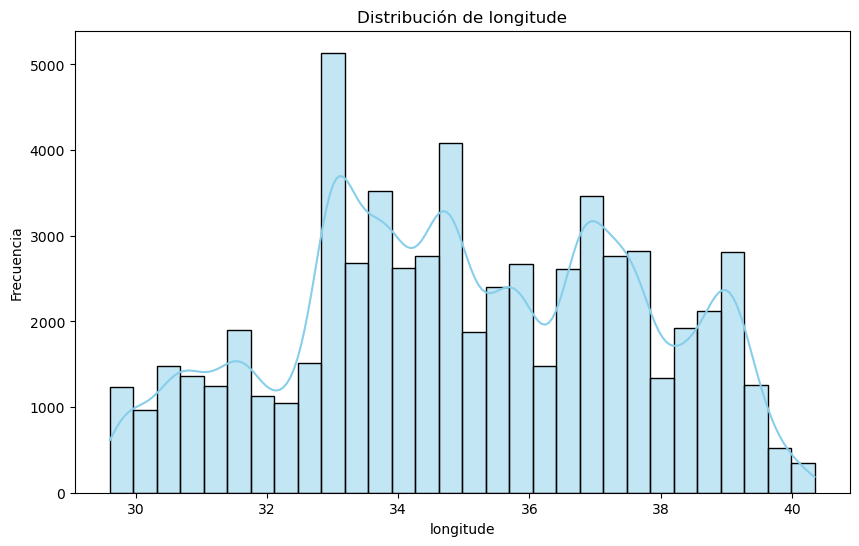

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


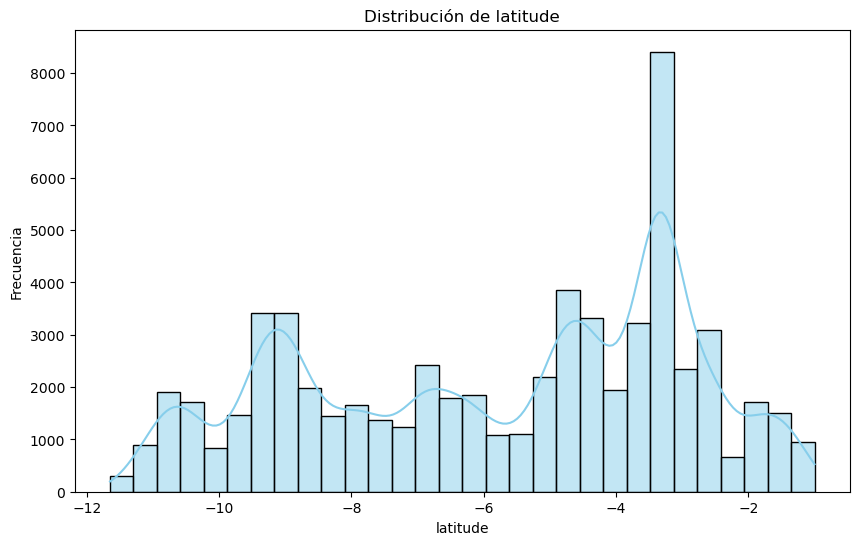

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


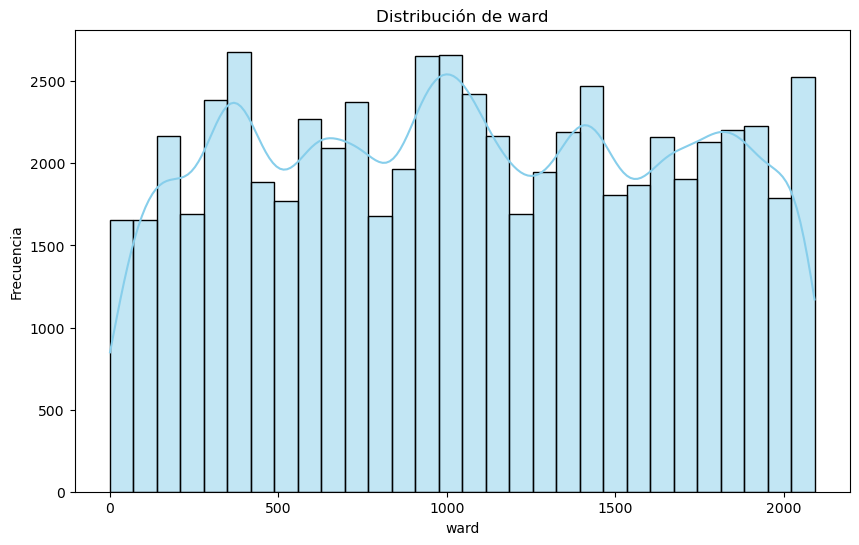

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


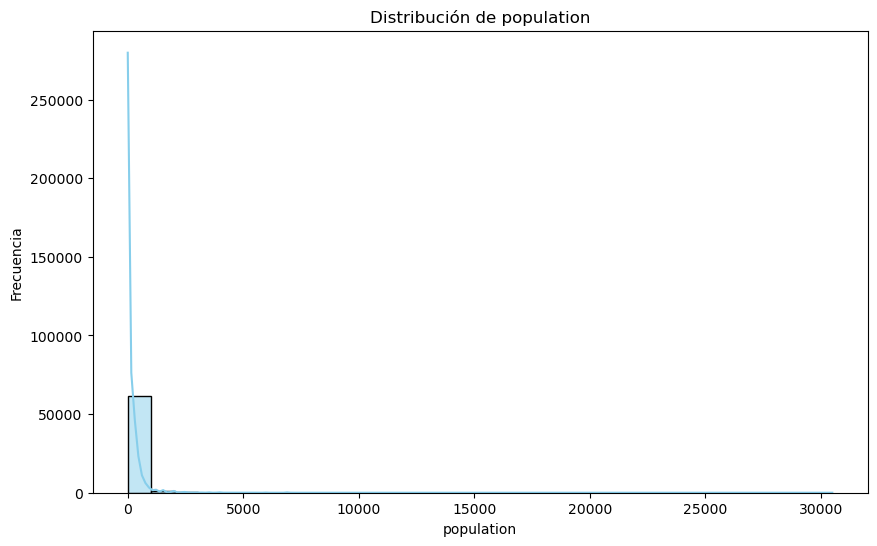

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


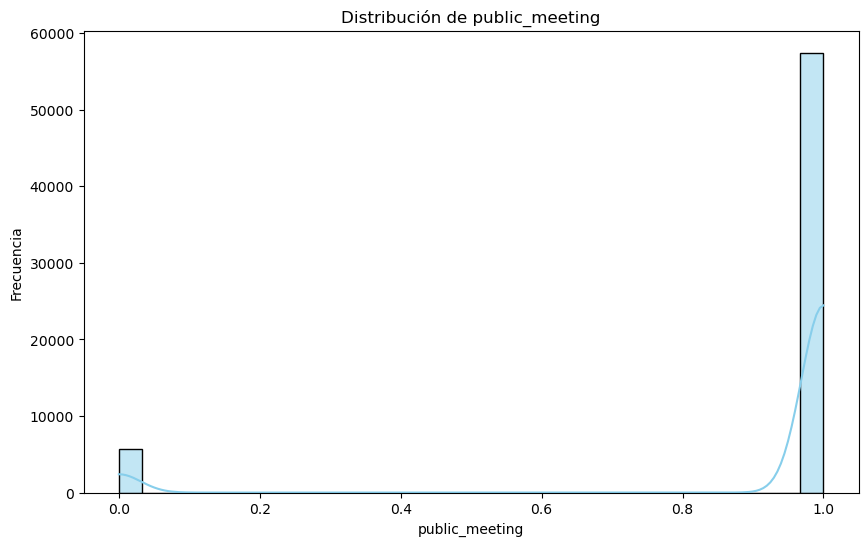

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


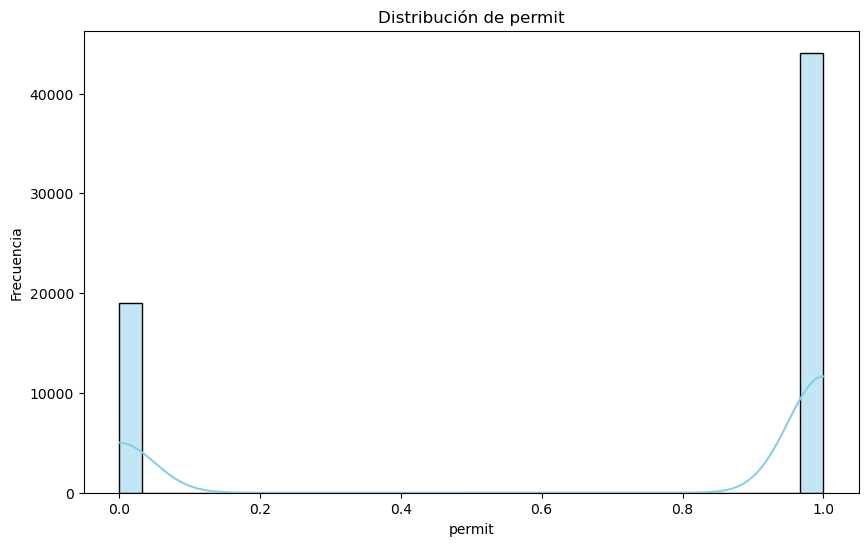

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


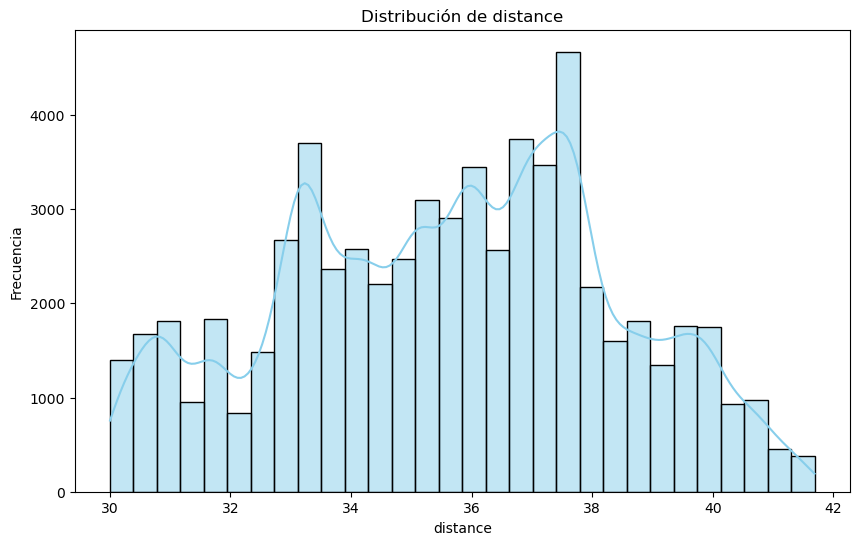

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


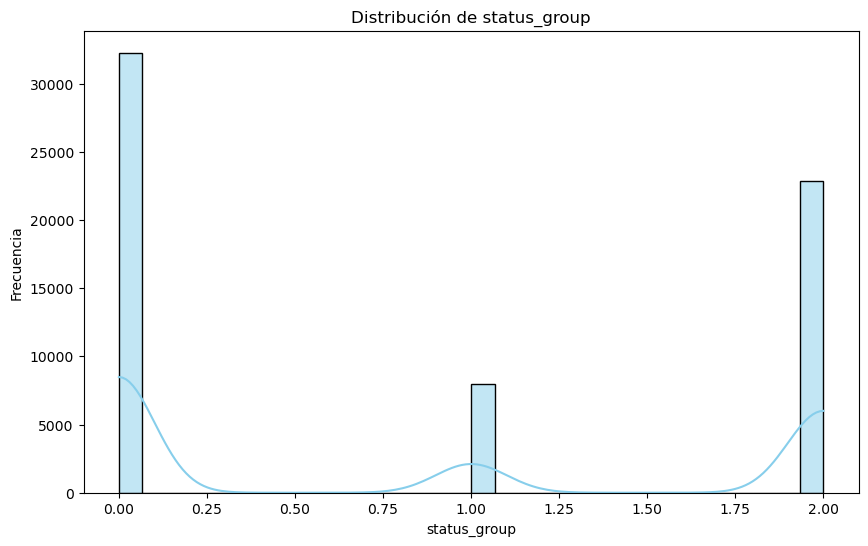

In [256]:
plot_numeric_distribution(data)

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


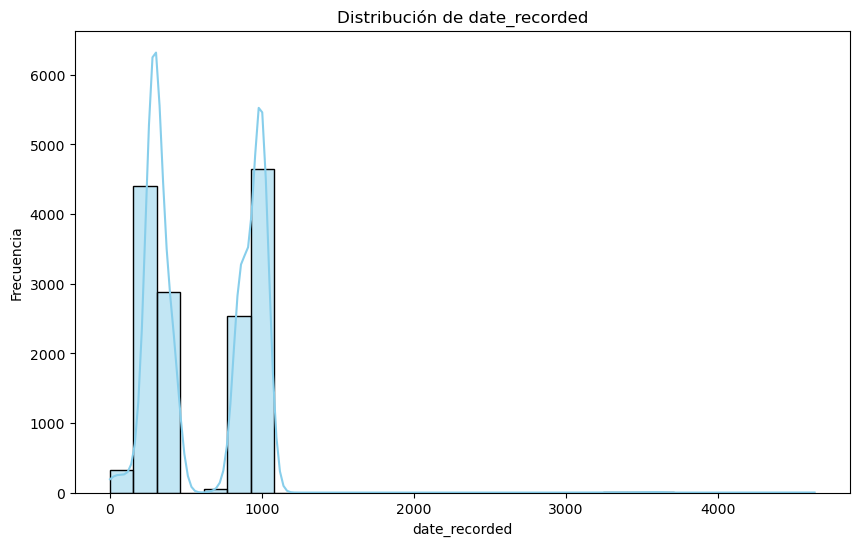

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


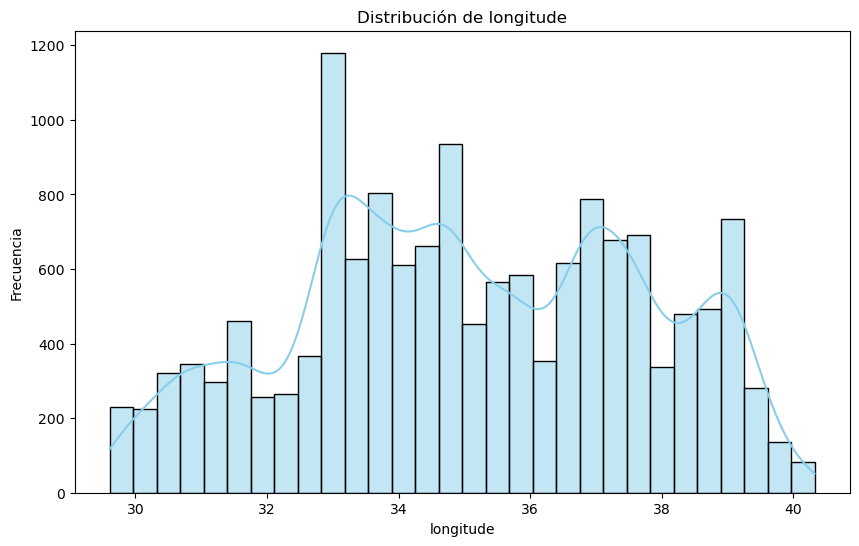

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


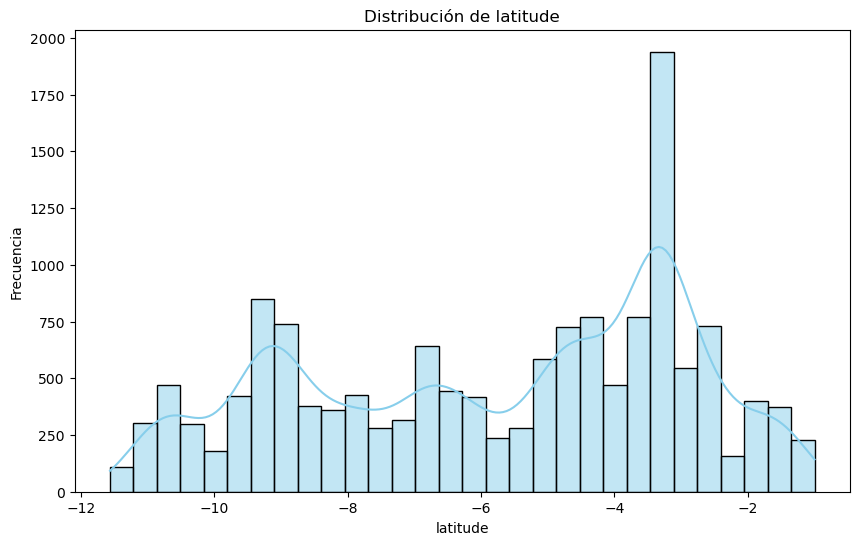

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


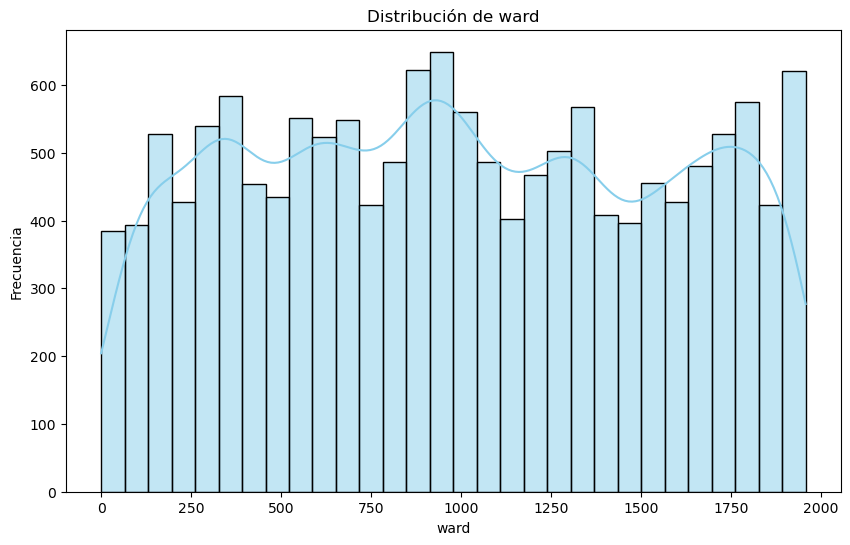

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


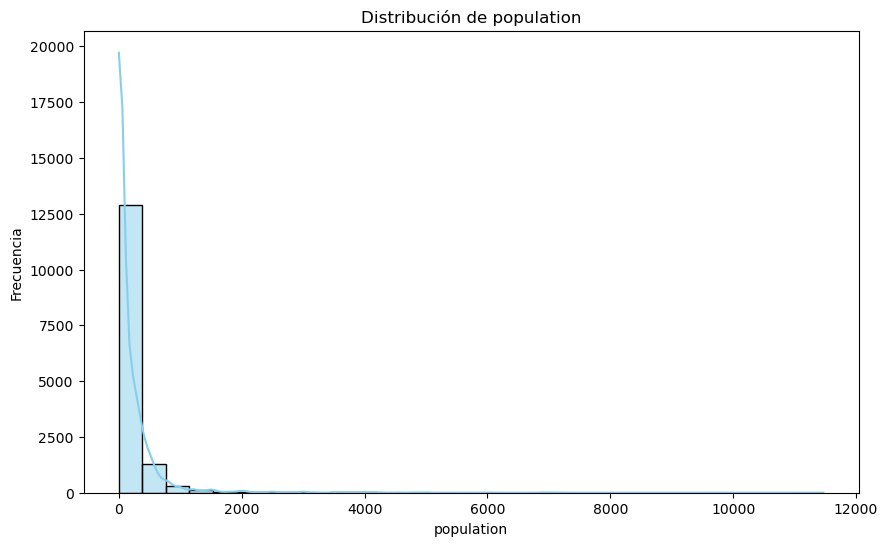

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


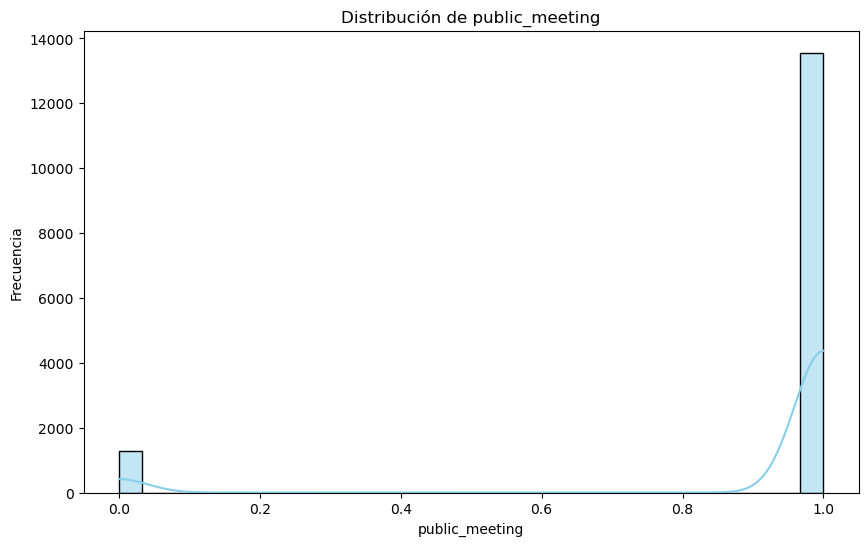

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


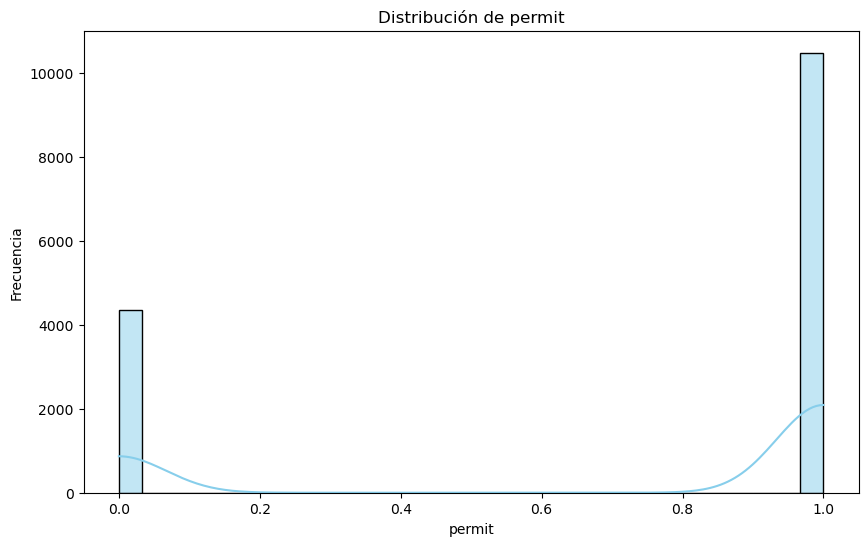

C:\Users\Guillermo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


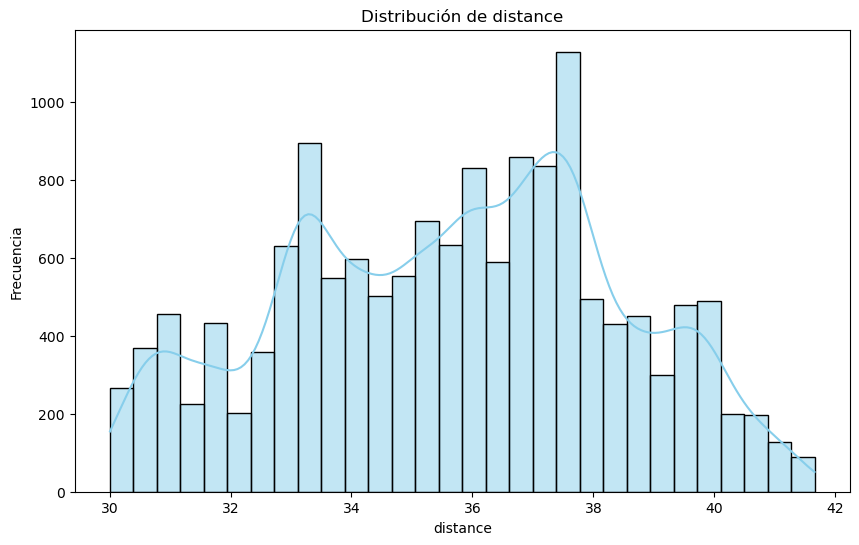

In [257]:
plot_numeric_distribution(data_test)

In [258]:
# Seleccionar solo las columnas numéricas
num_cols_corr = data.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = num_cols_corr.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


                date_recorded  longitude  latitude      ward  population  \
date_recorded        1.000000  -0.001686 -0.257021 -0.076746   -0.104186   
longitude           -0.001686   1.000000 -0.318410  0.062364    0.064423   
latitude            -0.257021  -0.318410  1.000000  0.010703   -0.009450   
ward                -0.076746   0.062364  0.010703  1.000000    0.029311   
population          -0.104186   0.064423 -0.009450  0.029311    1.000000   
public_meeting       0.036451   0.025226  0.002855 -0.020470    0.008940   
permit              -0.035794   0.016349  0.086607  0.014233   -0.032441   
distance             0.038877   0.985194 -0.473852  0.055530    0.060122   
status_group        -0.029799   0.001440 -0.012365  0.011764   -0.017432   

                public_meeting    permit  distance  status_group  
date_recorded         0.036451 -0.035794  0.038877     -0.029799  
longitude             0.025226  0.016349  0.985194      0.001440  
latitude              0.002855  0.0866

In [259]:
data.shape

(63083, 120)

In [260]:
data_test.shape

(14850, 119)

In [261]:
# Chequeo las diferencias entre data y data_test.

columns_data = set(data.columns)
columns_data_test = set(data_test.columns)

# Encontrar las columnas que están en 'data' pero no en 'data_test'
columns_missing_in_data_test = columns_data - columns_data_test

# Encontrar las columnas que están en 'data_test' pero no en 'data'
columns_missing_in_data = columns_data_test - columns_data

print("Columnas en data pero no en data_test:", columns_missing_in_data_test)
print("Columnas en data_test pero no en data:", columns_missing_in_data)

Columnas en data pero no en data_test: {'status_group'}
Columnas en data_test pero no en data: set()


In [262]:
data.to_csv("training_set_values_pp6.csv", index = False)

In [263]:
data_test.to_csv("test_set_values_pp6.csv", index = False)